In [128]:
# Import Required Libraries
import pandas as pd
import numpy as np
import string
from datetime import date
import os

#importing matplotlib.pyplot for statistical plots
import matplotlib.pyplot as plt
%matplotlib inline

#importing seaborn for statistical plots
import seaborn as sns
from scipy.stats import zscore
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn. naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
import lightgbm as lgb
import xgboost as xgb

#metrics
from sklearn.metrics import accuracy_score, precision_score, average_precision_score, classification_report

#set display options to see all rows and columns
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

## Load data files and read into a DataFrame

In [4]:
#%ls 'drive/My Drive/AIML/Hackathon_04122020_05122020/'
#%ls

In [5]:
#file_path = 'drive/My Drive/AIML/Hackathon_04122020_05122020/'

In [6]:
#list all the mf files in the directory
mf_files = [x for x in os.listdir() if x.endswith('.csv') and x != 'sample_submission.csv']
#mf_files = [x for x in os.listdir(file_path) if x.endswith('.csv') and x != 'sample_submission.csv']
#mf_files

In [7]:
# check the shape of each dataframe and also the first few rows
#column_sum=0
#for f in enumerate(mf_files):
    #df = 'df'+ str(f[0])
    #print(df, f[1])
    #df = pd.read_csv(f[1])
    #df = pd.read_csv(file_path + f[1])
    #print('Shape of {} : {}'.format(f[1],df.shape))
    #print(df.isna().sum(), '\n')
    #df.head(3)
    #column_sum += df.shape[1]
    #print(df.columns,'\n')
#print(column_sum)

In [8]:
#Read all the nine input files
df_br = pd.read_csv('bond_ratings.csv')
#df_br = pd.read_csv(file_path +'bond_ratings.csv')
df_fa = pd.read_csv('fund_allocations.csv')
#df_fa = pd.read_csv(file_path +'fund_allocations.csv')
df_fc = pd.read_csv('fund_config.csv')
#df_fc = pd.read_csv(file_path +'fund_config.csv')
df_fr = pd.read_csv('fund_ratios.csv')
#df_fr = pd.read_csv(file_path +'fund_ratios.csv')
df_fs = pd.read_csv('fund_specs.csv')
#df_fs = pd.read_csv(file_path +'fund_specs.csv')
df_os = pd.read_csv('other_specs.csv')
#df_os = pd.read_csv(file_path +'other_specs.csv')
df_r3 = pd.read_csv('return_3year.csv')
#df_r3 = pd.read_csv(file_path +'return_3year.csv')
df_r5 = pd.read_csv('return_5year.csv')
#df_r5 = pd.read_csv(file_path +'return_5year.csv')
df_r10 = pd.read_csv('return_10year.csv')
#df_r10 = pd.read_csv(file_path +'return_10year.csv')

In [9]:
#Merge all files data into one dataframe
data = pd.merge(df_br, df_fa, left_on='tag', right_on='id')
data = pd.merge(data, df_fr, on='tag')
data = pd.merge(data, df_fs, on='tag')
data = pd.merge(data, df_os, on='tag')
data = pd.merge(data, df_r3, on='tag')
data = pd.merge(data, df_r5, on='tag')
data = pd.merge(data, df_r10, on='fund_id')
data = pd.merge(data, df_fc, on='fund_id')

#check the shape of merged dataframe
data.shape

(25000, 132)

In [10]:
#Drop duplicate columns in dataset
for i in data.columns:
    if i.endswith('_x'):
        print(i, i[:len(i)-2])
        data = data.rename(columns={i:i[:len(i)-2]})
    if i.endswith('_y'):
        print(i)
        data = data.drop(i, axis=1)
        
#Drop id, currency, us_govt_bond_rating which are not reqired        
data = data.drop(['id', 'currency', 'us_govt_bond_rating'], axis=1)

pb_ratio_x pb_ratio
ps_ratio_x ps_ratio
mmc_x mmc
pc_ratio_x pc_ratio
pe_ratio_x pe_ratio
greatstone_rating_x greatstone_rating
pc_ratio_y
pb_ratio_y
pe_ratio_y
mmc_y
ps_ratio_y
fund_return_3years_x fund_return_3years
greatstone_rating_y
fund_return_3years_y


In [11]:
#Check the shape of dataset after removing duplicate columns and id column(duplicate for tag)
data.shape

(25000, 122)

In [12]:
#columns which are not numeric, ie string and datetime
data.select_dtypes(include='object').dtypes

fund_id                     object
ps_ratio                    object
mmc                         object
pc_ratio                    object
pe_ratio                    object
investment_class            object
inception_date              object
fund_size                   object
3yrs_treynor_ratio_fund     object
5yrs_treynor_ratio_fund     object
10yrs_treynor_ratio_fund    object
category                    object
parent_company              object
fund_name                   object
dtype: object

## Imputing Missing values in categorical columns

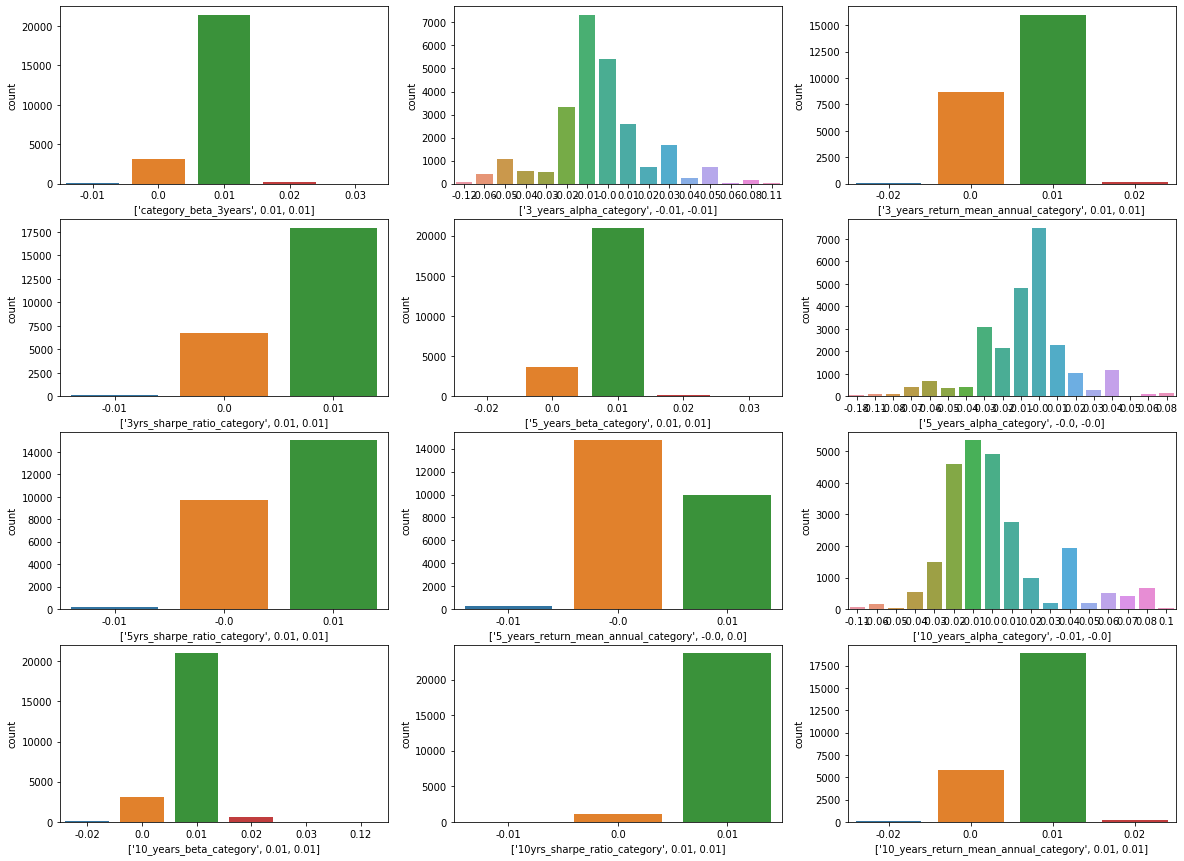

In [13]:
fig, ax = plt.subplots(4,3,figsize=(20, 15))
for col,subplot in zip(['category_beta_3years','3_years_alpha_category','3_years_return_mean_annual_category','3yrs_sharpe_ratio_category','5_years_beta_category','5_years_alpha_category','5yrs_sharpe_ratio_category','5_years_return_mean_annual_category','10_years_alpha_category','10_years_beta_category','10yrs_sharpe_ratio_category','10_years_return_mean_annual_category'],ax.flatten()):
        sns.countplot(col, data=data, ax=subplot)
        subplot.set_xlabel([col,data[col].mode()[0],data[col].median()])
plt.show()

In [14]:
#check the null values in categorical values
data[['greatstone_rating', 'fund_id', 'investment_class', 'inception_date', 'fund_size', 'category', 'parent_company', 'fund_name']].isna().sum()

greatstone_rating    5000
fund_id                 0
investment_class     1480
inception_date          0
fund_size            1480
category                0
parent_company          0
fund_name               0
dtype: int64

In [15]:
print(data.portfolio_cyclical_consumer_allocation.median())
data.groupby('greatstone_rating').median()['portfolio_cyclical_consumer_allocation']

10.46


greatstone_rating
0.0    10.115
1.0     7.260
2.0    10.310
3.0    10.620
4.0    10.710
5.0    11.055
Name: portfolio_cyclical_consumer_allocation, dtype: float64

In [16]:
#Replace missing values in 'investment_class' and 'fund_size' with mode of columns
data['investment_class'].fillna(data['investment_class'].mode()[0], inplace=True)
data['fund_size'].fillna(data['fund_size'].mode()[0], inplace=True)

In [17]:
#check the null values in categorical values
data[['greatstone_rating', 'fund_id', 'investment_class', 'inception_date', 'fund_size', 'category', 'parent_company', 'fund_name']].isna().sum()

greatstone_rating    5000
fund_id                 0
investment_class        0
inception_date          0
fund_size               0
category                0
parent_company          0
fund_name               0
dtype: int64

In [18]:
data['inception_year'] = data['inception_date'].str.split('-').str[0]
data['inception_year'] = data['inception_year'].astype(float)

In [19]:
#Convert inception date to number of years.
#The time in no of years since inception date may be a feature of importance 
from datetime import date
#Today's date
today = date.today()
#print(today)
data['yrs_since_inception'] = np.floor((pd.to_datetime(today)-pd.to_datetime(data['inception_date'])).dt.days/365.25)

In [20]:
#check dtype of yrs _since_inception
print(data['yrs_since_inception'].dtype, data['inception_year'] .dtype)

float64 float64


## Manual encoding of Categorical Variables

In [21]:
print("Number of unique companies",len(data.parent_company.unique()))
print("Number of unique fund names",len(data.fund_name.unique()))
print("Number of unique inception years",len(data.inception_year.unique()))

Number of unique companies 761
Number of unique fund names 24958
Number of unique inception years 88


In [22]:
#Can we weight a company's importance based on the yrs_since_inception
#ax=sns.countplot(data['yrs_since_inception'])
print(data.loc[(data['yrs_since_inception'] >=1) & (data['yrs_since_inception'] <10), 'yrs_since_inception'].count())
print(data.loc[(data['yrs_since_inception'] >=10) & (data['yrs_since_inception'] <20), 'yrs_since_inception'].count())
print(data.loc[(data['yrs_since_inception'] >=20) & (data['yrs_since_inception'] <30), 'yrs_since_inception'].count())
print(data.loc[(data['yrs_since_inception'] >=30) & (data['yrs_since_inception'] <40), 'yrs_since_inception'].count())
print(data.loc[(data['yrs_since_inception'] >=40) & (data['yrs_since_inception'] <50), 'yrs_since_inception'].count())
print(data.loc[(data['yrs_since_inception'] >=50) & (data['yrs_since_inception'] <60), 'yrs_since_inception'].count())
print(data.loc[(data['yrs_since_inception'] >=60) & (data['yrs_since_inception'] <70), 'yrs_since_inception'].count())
print(data.loc[(data['yrs_since_inception'] >=70) & (data['yrs_since_inception'] <80), 'yrs_since_inception'].count())
print(data.loc[(data['yrs_since_inception'] >=80) & (data['yrs_since_inception'] <90), 'yrs_since_inception'].count())
print(data.loc[(data['yrs_since_inception'] >=90) & (data['yrs_since_inception'] <100), 'yrs_since_inception'].count())

11693
8612
3810
657
122
42
19
19
19
7


In [23]:
#create new column 'fund_name_pri' which encodes fund_name based on yrs_since_inception
for rownum, row in enumerate(data.fund_name):
  if (data.loc[rownum,'yrs_since_inception'] >=1) & (data.loc[rownum, 'yrs_since_inception'] <10):
    data.loc[rownum,'fund_name_pri'] = 0
  elif(data.loc[rownum,'yrs_since_inception'] >=10) & (data.loc[rownum, 'yrs_since_inception'] <20):
    data.loc[rownum,'fund_name_pri'] = 1
  elif(data.loc[rownum,'yrs_since_inception'] >=20) & (data.loc[rownum, 'yrs_since_inception'] <30):
    data.loc[rownum,'fund_name_pri'] = 2
  elif(data.loc[rownum,'yrs_since_inception'] >=30) & (data.loc[rownum, 'yrs_since_inception'] <40):
    data.loc[rownum,'fund_name_pri'] = 3  
  elif(data.loc[rownum,'yrs_since_inception'] >=40) & (data.loc[rownum, 'yrs_since_inception'] <50):
    data.loc[rownum,'fund_name_pri'] = 4 
  elif(data.loc[rownum,'yrs_since_inception'] >=50) & (data.loc[rownum, 'yrs_since_inception'] <60):
    data.loc[rownum,'fund_name_pri'] = 5
  elif(data.loc[rownum,'yrs_since_inception'] >=60) & (data.loc[rownum, 'yrs_since_inception'] <70):
    data.loc[rownum,'fund_name_pri'] = 6
  elif(data.loc[rownum,'yrs_since_inception'] >=70) & (data.loc[rownum, 'yrs_since_inception'] <80):
    data.loc[rownum,'fund_name_pri'] = 7
  elif(data.loc[rownum,'yrs_since_inception'] >=80) & (data.loc[rownum, 'yrs_since_inception'] <90):
    data.loc[rownum,'fund_name_pri'] = 8
  elif(data.loc[rownum,'yrs_since_inception'] >=90) & (data.loc[rownum, 'yrs_since_inception'] <100):
    data.loc[rownum,'fund_name_pri'] = 9

In [24]:
data.fund_name_pri.value_counts()

0.0    11693
1.0     8612
2.0     3810
3.0      657
4.0      122
5.0       42
7.0       19
8.0       19
6.0       19
9.0        7
Name: fund_name_pri, dtype: int64

In [25]:
#value counts of investment_class column to be encoded
print(data['investment_class'].value_counts())

Blend     11778
Growth     6671
Value      6551
Name: investment_class, dtype: int64


In [26]:
#value counts of fund_size column to be encoded
print(data['fund_size'].value_counts())

Large     15653
Medium     6009
Small      3338
Name: fund_size, dtype: int64


In [27]:
#Number of unique categories to be encoded
print("Number of unique categories",len(data.category.unique()))
data.category.unique()

Number of unique categories 111


array(['Energy Limited Partnership', 'Large Growth', 'Large Value',
       'Target-Date 2035', 'Convertibles', 'Multialternative',
       'Foreign Large Value', 'Allocation - 15% to 30% Equity',
       'Long-Short Credit', 'Large Blend', 'Muni National Long',
       'Emerging Markets Bond', 'Muni Pennsylvania', 'Target-Date 2055',
       'Small Growth', 'Muni New York Intermediate', 'Corporate Bond',
       'Short-Term Bond', 'Foreign Large Blend', 'High Yield Bond',
       'Target-Date 2050', 'Muni National Short',
       'Allocation - 50% to 70% Equity', 'Market Neutral',
       'Long-Term Bond', 'Intermediate-Term Bond', 'World Allocation',
       'Mid-Cap Growth', 'Muni Minnesota', 'Allocation - 85%+ Equity',
       'Target-Date 2030', 'Target-Date Retirement', 'Multisector Bond',
       'Muni National Interm', 'Target-Date 2025', 'World Large Stock',
       'Foreign Small/Mid Value', 'Allocation - 30% to 50% Equity',
       'Technology', 'Europe Stock', 'Global Real Estate',
     

In [28]:
#Relationship between 'investment_class', 'fund_size' and 'category
data[['investment_class', 'fund_size', 'category']].sample(10)

investment_class fund_size                        category
12150            Blend     Large  Allocation - 30% to 50% Equity
15740           Growth    Medium                Multisector Bond
10091           Growth     Large               Target-Date 2060+
10468            Blend    Medium          Muni Single State Long
2107             Blend     Large        Allocation - 85%+ Equity
12632            Blend     Large            Foreign Large Growth
4517             Blend     Small                 High Yield Bond
1579            Growth     Large                    Large Growth
1571             Value    Medium         Foreign Small/Mid Value
8384             Blend     Large               Target-Date 2060+

In [29]:
# create new column 'category_pri' which encodes category based on investment_class and fund_size
for rownum, row in enumerate(data.category):
  if (data.loc[rownum,'fund_size'] =='Large') & (data.loc[rownum, 'investment_class'] =='Blend'):
    data.loc[rownum,'category_pri'] = 0
  elif(data.loc[rownum,'fund_size'] =='Large') & (data.loc[rownum, 'investment_class'] =='Growth'):
    data.loc[rownum,'category_pri'] = 1
  elif(data.loc[rownum,'fund_size'] =='Large') & (data.loc[rownum, 'investment_class'] =='Value'):
    data.loc[rownum,'category_pri'] = 2
  elif(data.loc[rownum,'fund_size'] =='Medium') & (data.loc[rownum, 'investment_class'] =='Blend'):
    data.loc[rownum,'category_pri'] = 3
  elif(data.loc[rownum,'fund_size'] =='Medium') & (data.loc[rownum, 'investment_class'] =='Growth'):
    data.loc[rownum,'category_pri'] = 5
  elif(data.loc[rownum,'fund_size'] =='Medium') & (data.loc[rownum, 'investment_class'] =='Value'):
    data.loc[rownum,'category_pri'] = 4
  elif(data.loc[rownum,'fund_size'] =='Small') & (data.loc[rownum, 'investment_class'] =='Blend'):
    data.loc[rownum,'category_pri'] = 7
  elif(data.loc[rownum,'fund_size'] =='Small') & (data.loc[rownum, 'investment_class'] =='Growth'):
    data.loc[rownum,'category_pri'] = 8
  elif(data.loc[rownum,'fund_size'] =='Small') & (data.loc[rownum, 'investment_class'] =='Value'):
    data.loc[rownum,'category_pri'] = 6

In [30]:
data.category_pri.value_counts()

0.0    8331
1.0    4135
2.0    3187
3.0    2449
4.0    1867
5.0    1693
6.0    1497
7.0     998
8.0     843
Name: category_pri, dtype: int64

## Label Encoding of Cateorical Variables

In [31]:
#label encoding of categorical variables
le = LabelEncoder()
data['investment_class'] = le.fit_transform(data['investment_class'])
le1 = LabelEncoder()
data['fund_size'] = le1.fit_transform(data['fund_size'])

In [32]:
le.classes_, le1.classes_

(array(['Blend', 'Growth', 'Value'], dtype=object),
 array(['Large', 'Medium', 'Small'], dtype=object))

In [33]:
data['fund_size'].unique(), data['investment_class'].unique()

(array([0, 1, 2], dtype=int64), array([2, 1, 0], dtype=int64))

## Ordinal Encoding of Categorical Variables

In [34]:
data.loc[:,'parent_company'].values

array(['DWS', 'Janus Henderson', 'Calvert Research and Management', ...,
       'OppenheimerFunds', 'Miller Value Funds', 'DWS'], dtype=object)

In [35]:
#Ordinal encoding of categorical variables
oe = OrdinalEncoder()
data['parent_company'] = oe.fit_transform(data.loc[:,'parent_company'].values.reshape(-1,1))

In [36]:
len(data['parent_company'].unique())

761

In [37]:
#data['inception_year'].value_counts()

In [38]:
#data.groupby('inception_year')['fund_name'].count()

## Imputing Missing Values in numeric columns

In [39]:
#Convert string columns to float
for i in ['ps_ratio', 'mmc', 'pc_ratio', 'pe_ratio', '3yrs_treynor_ratio_fund', '5yrs_treynor_ratio_fund','10yrs_treynor_ratio_fund']:
    data[i] = data.loc[:,i].str.replace(',', '').astype(float)
#fund_id, investment_class, inception_date, fund_size, category, parent_company, fund_name

In [40]:
#check the columns after conversion
#data.loc[3470:3478,'ps_ratio']

In [41]:
#columns which are numeric
data.select_dtypes(include='number').dtypes

bb_rating                                 float64
below_b_rating                            float64
others_rating                             float64
maturity_bond                             float64
b_rating                                  float64
tag                                         int64
a_rating                                  float64
aaa_rating                                float64
aa_rating                                 float64
bbb_rating                                float64
duration_bond                             float64
portfolio_communication_allocation        float64
portfolio_financial_services              float64
portfolio_industrials_allocation          float64
portfolio_tech_allocation                 float64
portfolio_materials_basic_allocation      float64
portfolio_energy_allocation               float64
portfolio_consumer_defence_allocation     float64
portfolio_healthcare_allocation           float64
portfolio_property_allocation             float64


In [42]:
#Check for Missing or null values in the columns
data.isna().sum()

bb_rating                                   114
below_b_rating                              114
others_rating                               114
maturity_bond                             16907
b_rating                                    114
tag                                           0
a_rating                                    114
aaa_rating                                  114
aa_rating                                   114
bbb_rating                                  114
duration_bond                             15126
portfolio_communication_allocation          114
portfolio_financial_services                114
portfolio_industrials_allocation            114
portfolio_tech_allocation                   114
portfolio_materials_basic_allocation        114
portfolio_energy_allocation                 114
portfolio_consumer_defence_allocation       114
portfolio_healthcare_allocation             114
portfolio_property_allocation               114
portfolio_utils_allocation              

In [43]:
#Drop columns having very high no of missing values
data = data.drop(['maturity_bond', 'duration_bond'], axis=1)
data = data.drop(['2010_return_category','2011_return_category','2010_return_fund','2011_return_fund'],axis=1)

In [44]:
#scale mms column by dividing by 10000
#data['mmc_scaled'] = round(data['mmc']/10000,3)

In [45]:
#np.max(data['total_assets']), np.min(data['total_assets'])

In [46]:
#scale total_asssets column by dividing by 10000000
#data['total_assets_scaled'] = round(data['total_assets']/10000000,3)

In [47]:
#Impute missing values in numeric columns using kNN Imputation
#numeric_data = data.drop(['mmc', 'total_assets', 'greatstone_rating', 'fund_id', 'investment_class', 'inception_date', 'fund_size', 'category', 'parent_company', 'fund_name'], axis=1)
#numeric_columns = numeric_data.columns
#print("Number of numeric columns being imputed:", len(numeric_columns))
#imputer = KNNImputer(n_neighbors=10, weights="uniform")
#imputed_values = imputer.fit_transform(numeric_data)

In [48]:
#convert the numeric columns after imputation to a dataframe
#data_imputed = pd.DataFrame(imputed_values, columns=numeric_columns)
#data_imputed.shape

In [49]:
#data_imputed.head()

In [50]:
#data_imputed.isna().sum()

In [51]:
#Imputing null values in numeric columns with Median of the column
numeric_data = data.drop(['greatstone_rating', 'fund_id', 'inception_date', 'category', 'fund_name'], axis=1)
numeric_columns = numeric_data.columns
print(numeric_data.shape, numeric_data['bbb_rating'].dtype )
#print(numeric_data['bbb_rating'].median())
for col in numeric_data.columns:
    if(numeric_data[col].isna().sum() > 0):
        #print(numeric_data[col].mean(), '\t', numeric_data[col].median())
        numeric_data[col] = numeric_data[col].fillna(numeric_data[col].median())
        
        #q1 = numeric_data[col].quantile(0.25)
        #q3 = numeric_data[col].quantile(0.75)
        #iqr = q3 - q1
        #lower_limit = q1 - 1.5*iqr
        #upper_limit = q3 + 1.5*iqr
        #numeric_data[col] = numeric_data[col].fillna(np.random.uniform(lower_limit,upper_limit))
        #print(numeric_data[col])
        numeric_data[col].astype(float)
print(numeric_data.shape, numeric_data['bbb_rating'].dtype)

(25000, 115) float64
(25000, 115) float64


In [52]:
#numeric_data.dtypes

In [53]:
#df = pd.concat([data[['fund_id','greatstone_rating', 'investment_class', 'fund_size']], data_imputed], axis=1)
#df = pd.concat([data[['fund_id','greatstone_rating', 'investment_class', 'fund_size']], numeric_data], axis=1)
portfolios = ['portfolio_communication_allocation','portfolio_financial_services','portfolio_industrials_allocation',
              'portfolio_tech_allocation','portfolio_materials_basic_allocation','portfolio_energy_allocation','portfolio_consumer_defence_allocation','portfolio_healthcare_allocation',
              'portfolio_property_allocation','portfolio_utils_allocation','portfolio_cyclical_consumer_allocation','portfolio_convertable','portfolio_others','portfolio_preferred']
#drop_cols = ['2012_return_category','2013_category_return','2012_fund_return','2013_return_fund','fund_return_3years','3_years_return_category','5_years_return_fund','5_years_return_category','10_years_return_fund','10_years_return_category']
#drop_cols = ['2012_return_category','2013_category_return','2012_fund_return','2013_return_fund']

df = pd.concat([data[['fund_id','greatstone_rating']],
                numeric_data.drop(['return_ytd','fund_return_3months', '3_months_return_category','inception_year'],axis=1)], axis=1)
df = df.drop(portfolios, axis=1)
#df = df.drop(drop_cols, axis=1)

In [54]:
print(df.shape)

(25000, 99)


In [55]:
#df.dtypes

In [56]:
#df.isna().sum()

## EDA and Data Visualization

In [57]:
#data_imputed.describe()
numeric_data.describe()

bb_rating  below_b_rating  others_rating      b_rating  \
count  25000.000000    25000.000000   25000.000000  25000.000000   
mean       3.457963        0.823751       1.659168      3.219650   
std        8.284109        2.694432       6.870359      9.178757   
min        0.000000       -0.020000     -68.210000     -0.120000   
25%        0.000000        0.000000       0.000000      0.000000   
50%        0.000000        0.000000       0.000000      0.000000   
75%        2.420000        0.100000       0.320000      0.700000   
max       80.470000       42.300000     100.000000     80.680000   

                 tag      a_rating    aaa_rating     aa_rating    bbb_rating  \
count   25000.000000  25000.000000  25000.000000  25000.000000  25000.000000   
mean   139878.934640      5.031388     14.491924      4.189880      6.098324   
std     65731.287074      9.246942     25.597117     11.142635     10.581823   
min     26000.000000      0.000000     -3.150000     -0.190000      0.000000   
25%     83021.750000      0.000000      0.000000      0.000000      0.000000   
50%    139881.500000      0.000000      0.000000      0.000000      0.000000   
75%    196759.250000      8.277500     18.420000      2.990000     11.340000   
max    253763.000000     72.870000    118.650000     90.220000     98.000000   

       portfolio_communication_allocation  portfolio_financial_services  \
count                        25000.000000                  25000.000000   
mean                             2.267289                     11.843972   
std                              4.395191                     12.258711   
min                              0.000000                      0.000000   
25%                              0.000000                      0.000000   
50%                              1.180000                     13.120000   
75%                              3.400000                     17.900000   
max                            100.000000                    100.000000   

       portfolio_industrials_allocation  portfolio_tech_allocation  \
count                      25000.000000               25000.000000   
mean                           9.058340                  12.780539   
std                           10.147271                  12.529556   
min                            0.000000                   0.000000   
25%                            0.000000                   0.000000   
50%                            9.570000                  12.885000   
75%                           12.730000                  19.590000   
max                          100.000000                 100.000000   

       portfolio_materials_basic_allocation  portfolio_energy_allocation  \
count                          25000.000000                 25000.000000   
mean                               3.893197                     5.815490   
std                                8.118093                    13.656952   
min                                0.000000                     0.000000   
25%                                0.000000                     0.000000   
50%                                2.790000                     3.380000   
75%                                5.050000                     6.222500   
max                              100.000000                   100.000000   

       portfolio_consumer_defence_allocation  portfolio_healthcare_allocation  \
count                           25000.000000                     25000.000000   
mean                                5.110096                         8.540715   
std                                 6.064673                         9.596698   
min                                 0.000000                         0.000000   
25%                                 0.000000                         0.000000   
50%                                 4.840000                         9.370000   
75%                                 7.870000                        13.550000   
max                               10

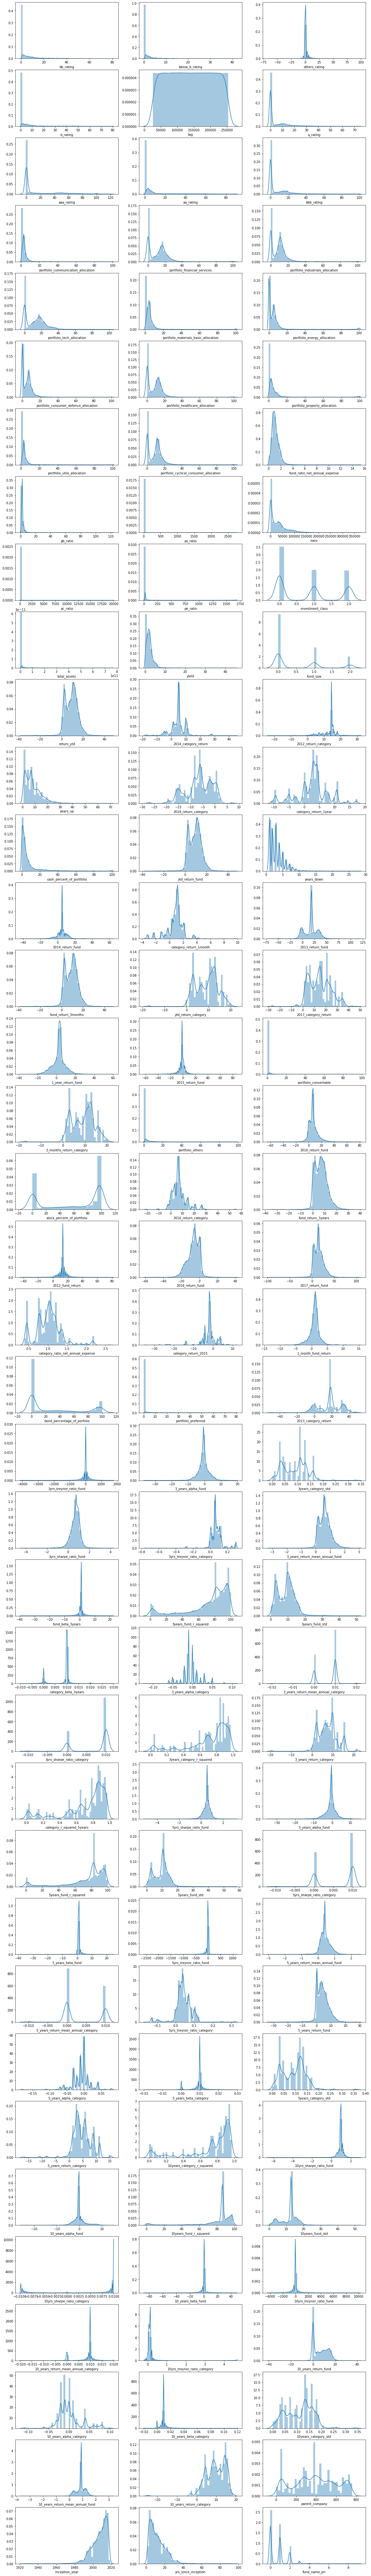

In [58]:
fig, ax = plt.subplots(38,3,figsize=(20, 150))
for col,subplot in zip(numeric_data.columns,ax.flatten()) :
    sns.distplot(numeric_data[col], ax=subplot)
plt.show()

In [59]:
#Function to find outliers
def identify_outliers(col):    
    q1 = numeric_data[col].quantile(0.25)
    q3 = numeric_data[col].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5*iqr
    upper_limit = q3 + 1.5*iqr
    return(col, q1, q3, iqr, lower_limit, upper_limit)

In [60]:
#Detect and impute outliers if required
#outlier_df = pd.DataFrame(columns=['column_name', 'outlier_count'])
#unskewed_list = ['category_beta_3years','3_years_alpha_category','3_years_return_mean_annual_category','3yrs_sharpe_ratio_category','5_years_beta_category','5_years_alpha_category','5yrs_sharpe_ratio_category','5_years_return_mean_annual_category','10_years_alpha_category','10_years_beta_category','10yrs_sharpe_ratio_category','10_years_return_mean_annual_category','tag','investment_class','fund_size','fund_name_pri','category_pri','yrs_since_inception','parent_company','stock_percent_of_portfolio','bond_percentage_of_porfolio','3years_category_r_squared','category_r_squared_5years','10years_category_r_squared']
#median_list = ['category_beta_3years','3_years_alpha_category','5_years_beta_category','5_years_alpha_category','10_years_alpha_category','10_years_beta_category','10yrs_sharpe_ratio_category','10_years_return_mean_annual_category','3years_category_r_squared','category_r_squared_5years','10years_category_r_squared','3_years_return_mean_annual_category']
#no_outlier_list = ['3yrs_sharpe_ratio_category','5yrs_sharpe_ratio_category','5_years_return_mean_annual_category','tag','investment_class','fund_size','fund_name_pri','category_pri','yrs_since_inception','parent_company','stock_percent_of_portfolio','bond_percentage_of_porfolio']
for col in numeric_data.columns :
    col, q1, q3, iqr, lower_limit, upper_limit = identify_outliers(col)
    print("\nColumn name : {}\n Q1 = {} \n Q3 = {}\n IQR = {}".format(col, q1, q3, iqr))
    print(" Lower limit = {}\n Upper limit = {}\n".format(lower_limit, upper_limit))
    outlier_count = len(numeric_data.loc[(numeric_data[col] < lower_limit) | (numeric_data[col] > upper_limit)])
    if outlier_count != 0 :
        print(outlier_count, "OUTLIERS ARE PRESENT in {} column.".format(col))
        #print("Outlier datapoints in {} column are:".format(col))
        #print(np.array(numeric_data.loc[(numeric_data[col] < lower_limit) | (numeric_data[col] > upper_limit)][col]))     
        #print(zscore(np.array(numeric_data.loc[(numeric_data[col] < lower_limit) | (numeric_data[col] > upper_limit)][col])))
        #print("Replacing Outliers with random value between lower and upper limits of the column {}...".format(col))
        #numeric_data.loc[(numeric_data[col] < lower_limit) | (numeric_data[col] > upper_limit), col] = numeric_data.loc[(numeric_data[col] < lower_limit) | (numeric_data[col] > upper_limit), col].apply(lambda x : np.random.uniform(lower_limit,upper_limit))
        #print('...Outliers are replaced with random number between lower limit and upper limit')
        #if col in median_list:
            #print("Replacing Outliers with mean/median of the column {}...".format(col))
            #numeric_data.loc[(numeric_data[col] < lower_limit) | (numeric_data[col] > upper_limit), col] = np.nan
            #numeric_data[col].fillna(round(numeric_data[col].median()), inplace=True)    
            #print('...Outliers are replaced with mean/median')
        #else:
            #print("Replacing Outliers with random value between lower and upper limits of the column {}...".format(col))
            #numeric_data.loc[(numeric_data[col] < lower_limit) | (numeric_data[col] > upper_limit), col] = numeric_data.loc[(numeric_data[col] < lower_limit) | (numeric_data[col] > upper_limit), col].apply(lambda x : np.random.uniform(lower_limit,upper_limit))
            #print('...Outliers are replaced with random number between lower limit and upper limit')
    else:
        print("OUTLIERS ARE NOT PRESENT in {} column\n".format(col))


Column name : bb_rating
 Q1 = 0.0 
 Q3 = 2.42
 IQR = 2.42
 Lower limit = -3.63
 Upper limit = 6.05

4166 OUTLIERS ARE PRESENT in bb_rating column.

Column name : below_b_rating
 Q1 = 0.0 
 Q3 = 0.1
 IQR = 0.1
 Lower limit = -0.15000000000000002
 Upper limit = 0.25

5705 OUTLIERS ARE PRESENT in below_b_rating column.

Column name : others_rating
 Q1 = 0.0 
 Q3 = 0.32
 IQR = 0.32
 Lower limit = -0.48
 Upper limit = 0.8

5766 OUTLIERS ARE PRESENT in others_rating column.

Column name : b_rating
 Q1 = 0.0 
 Q3 = 0.7
 IQR = 0.7
 Lower limit = -1.0499999999999998
 Upper limit = 1.7499999999999998

5406 OUTLIERS ARE PRESENT in b_rating column.

Column name : tag
 Q1 = 83021.75 
 Q3 = 196759.25
 IQR = 113737.5
 Lower limit = -87584.5
 Upper limit = 367365.5

OUTLIERS ARE NOT PRESENT in tag column


Column name : a_rating
 Q1 = 0.0 
 Q3 = 8.2775
 IQR = 8.2775
 Lower limit = -12.41625
 Upper limit = 20.69375

1908 OUTLIERS ARE PRESENT in a_rating column.

Column name : aaa_rating
 Q1 = 0.0 
 Q3

 Lower limit = 8.525000000000002
 Upper limit = 18.404999999999998

6020 OUTLIERS ARE PRESENT in 2012_fund_return column.

Column name : 2018_return_fund
 Q1 = -10.22 
 Q3 = -1.84
 IQR = 8.38
 Lower limit = -22.79
 Upper limit = 10.73

444 OUTLIERS ARE PRESENT in 2018_return_fund column.

Column name : 2017_return_fund
 Q1 = 7.0175 
 Q3 = 21.1
 IQR = 14.082500000000001
 Lower limit = -14.106250000000001
 Upper limit = 42.22375

442 OUTLIERS ARE PRESENT in 2017_return_fund column.

Column name : category_ratio_net_annual_expense
 Q1 = 0.81 
 Q3 = 1.18
 IQR = 0.3699999999999999
 Lower limit = 0.2550000000000002
 Upper limit = 1.7349999999999999

858 OUTLIERS ARE PRESENT in category_ratio_net_annual_expense column.

Column name : category_return_2015
 Q1 = -2.58 
 Q3 = -0.95
 IQR = 1.6300000000000001
 Lower limit = -5.025
 Upper limit = 1.4950000000000003

6211 OUTLIERS ARE PRESENT in category_return_2015 column.

Column name : 1_month_fund_return
 Q1 = 0.35 
 Q3 = 1.71
 IQR = 1.359999999


3864 OUTLIERS ARE PRESENT in 10_years_beta_category column.

Column name : 10years_category_std
 Q1 = 0.06 
 Q3 = 0.15
 IQR = 0.09
 Lower limit = -0.07500000000000001
 Upper limit = 0.28500000000000003

57 OUTLIERS ARE PRESENT in 10years_category_std column.

Column name : 10_years_return_mean_annual_fund
 Q1 = 0.75 
 Q3 = 1.06
 IQR = 0.31000000000000005
 Lower limit = 0.2849999999999999
 Upper limit = 1.5250000000000001

2112 OUTLIERS ARE PRESENT in 10_years_return_mean_annual_fund column.

Column name : 10_years_return_category
 Q1 = 6.44 
 Q3 = 14.12
 IQR = 7.679999999999999
 Lower limit = -5.079999999999997
 Upper limit = 25.639999999999997

53 OUTLIERS ARE PRESENT in 10_years_return_category column.

Column name : parent_company
 Q1 = 239.75 
 Q3 = 547.0
 IQR = 307.25
 Lower limit = -221.125
 Upper limit = 1007.875

OUTLIERS ARE NOT PRESENT in parent_company column


Column name : inception_year
 Q1 = 2002.0 
 Q3 = 2014.0
 IQR = 12.0
 Lower limit = 1984.0
 Upper limit = 2032.0

3

In [61]:
#fig, ax = plt.subplots(38,3,figsize=(20, 150))
#for col,subplot in zip(numeric_data.columns,ax.flatten()) :
    #sns.distplot(numeric_data[col], ax=subplot)
#plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


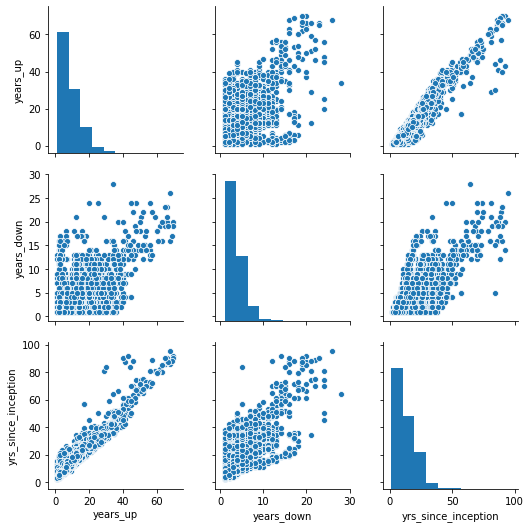

In [62]:
ax = sns.pairplot(data, vars=['years_up', 'years_down', 'yrs_since_inception'], kind='scatter', diag_kind='hist')

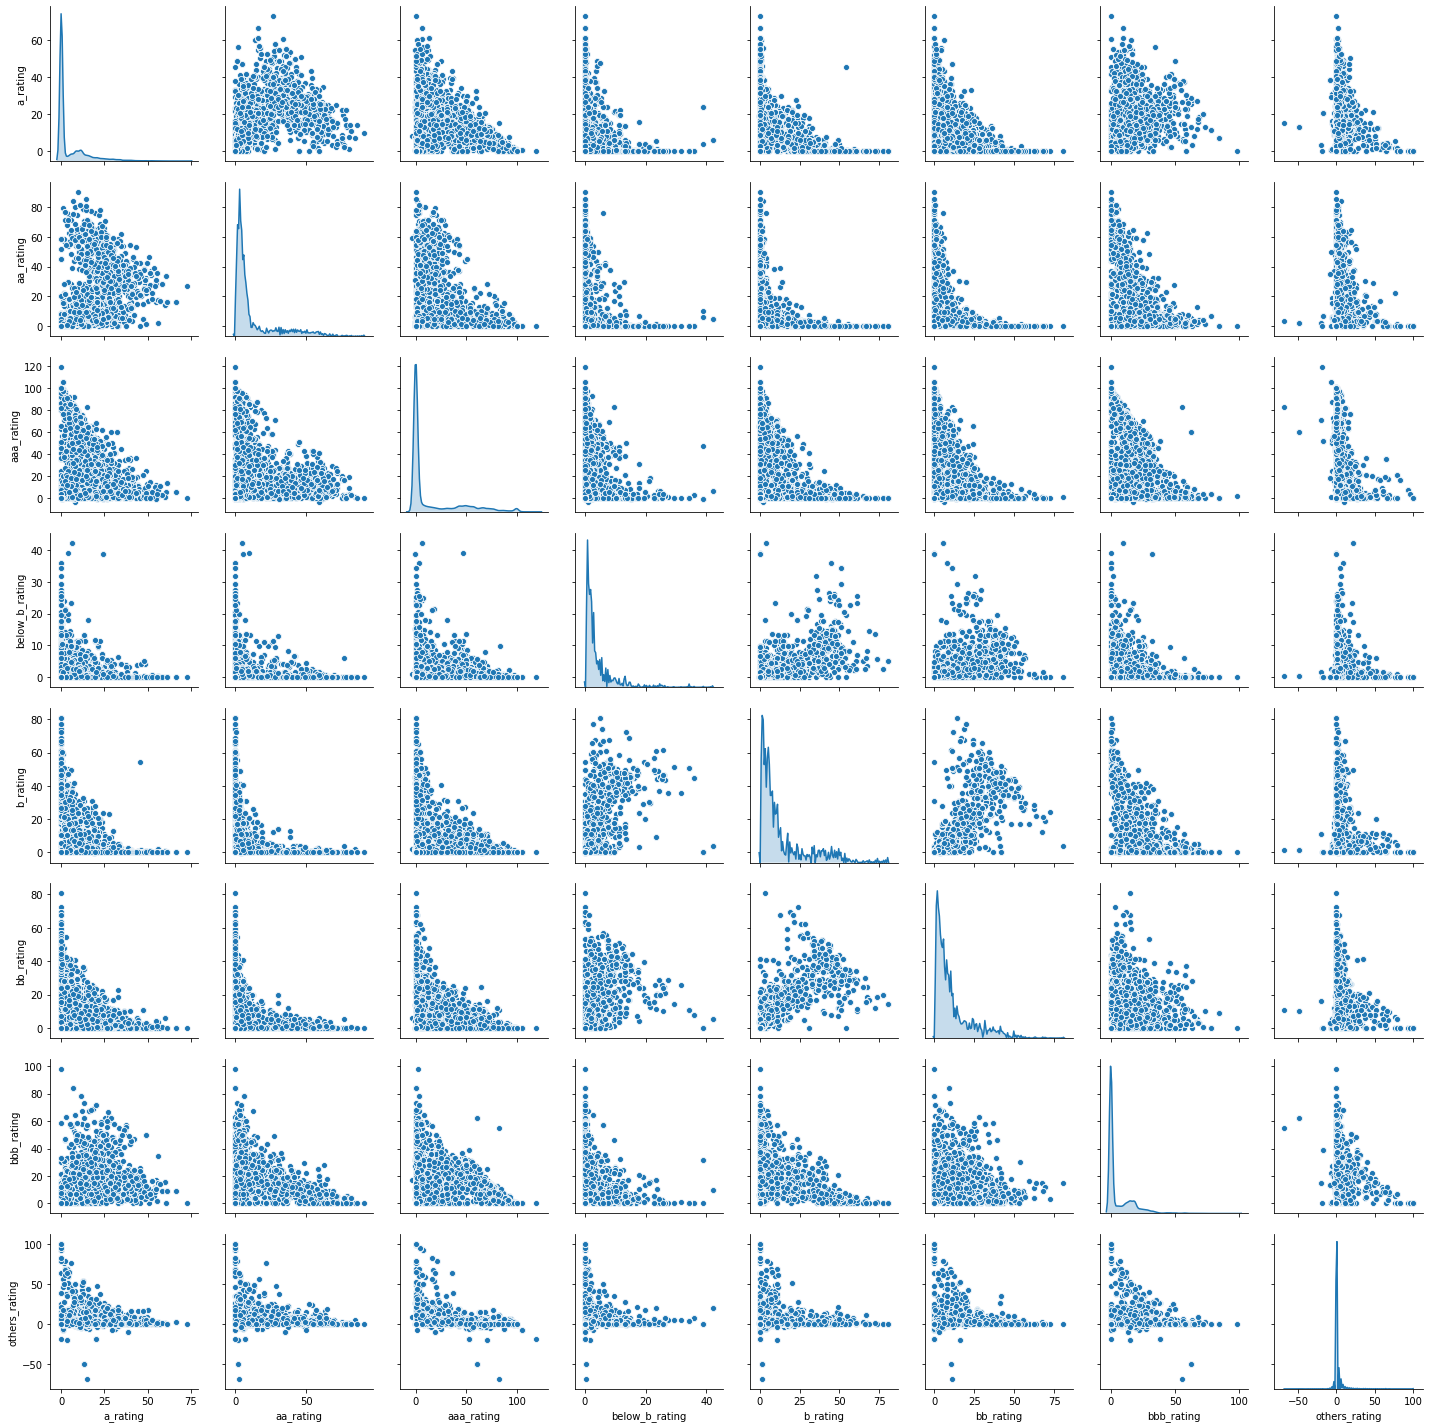

In [63]:
ax = sns.pairplot(df, vars=['a_rating','aa_rating','aaa_rating','below_b_rating','b_rating','bb_rating','bbb_rating','others_rating'],
                  kind='scatter', diag_kind='kde')

3.0    6786
4.0    4614
2.0    4230
5.0    1629
1.0    1376
0.0    1365
Name: greatstone_rating, dtype: int64


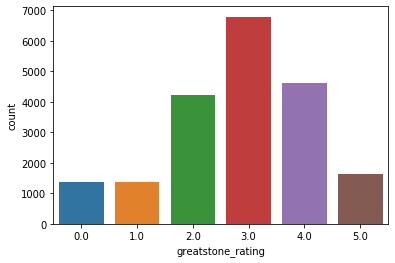

In [64]:
print(df.greatstone_rating.value_counts())
ax = sns.countplot('greatstone_rating', data=df)

0    11778
1     6671
2     6551
Name: investment_class, dtype: int64


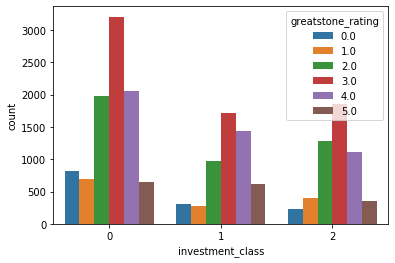

In [65]:
print(df.investment_class.value_counts())
ax = sns.countplot('investment_class',hue='greatstone_rating', data=df)

3


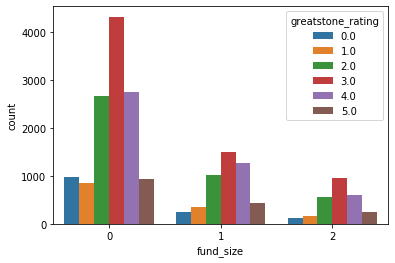

In [66]:
print(len(df.fund_size.unique()))
ax = sns.countplot('fund_size',hue='greatstone_rating', data=df)

In [67]:
plt.figure(figsize=(250,150))
sns.countplot(df.parent_company.value_counts(), data=data)
plt.show()

111


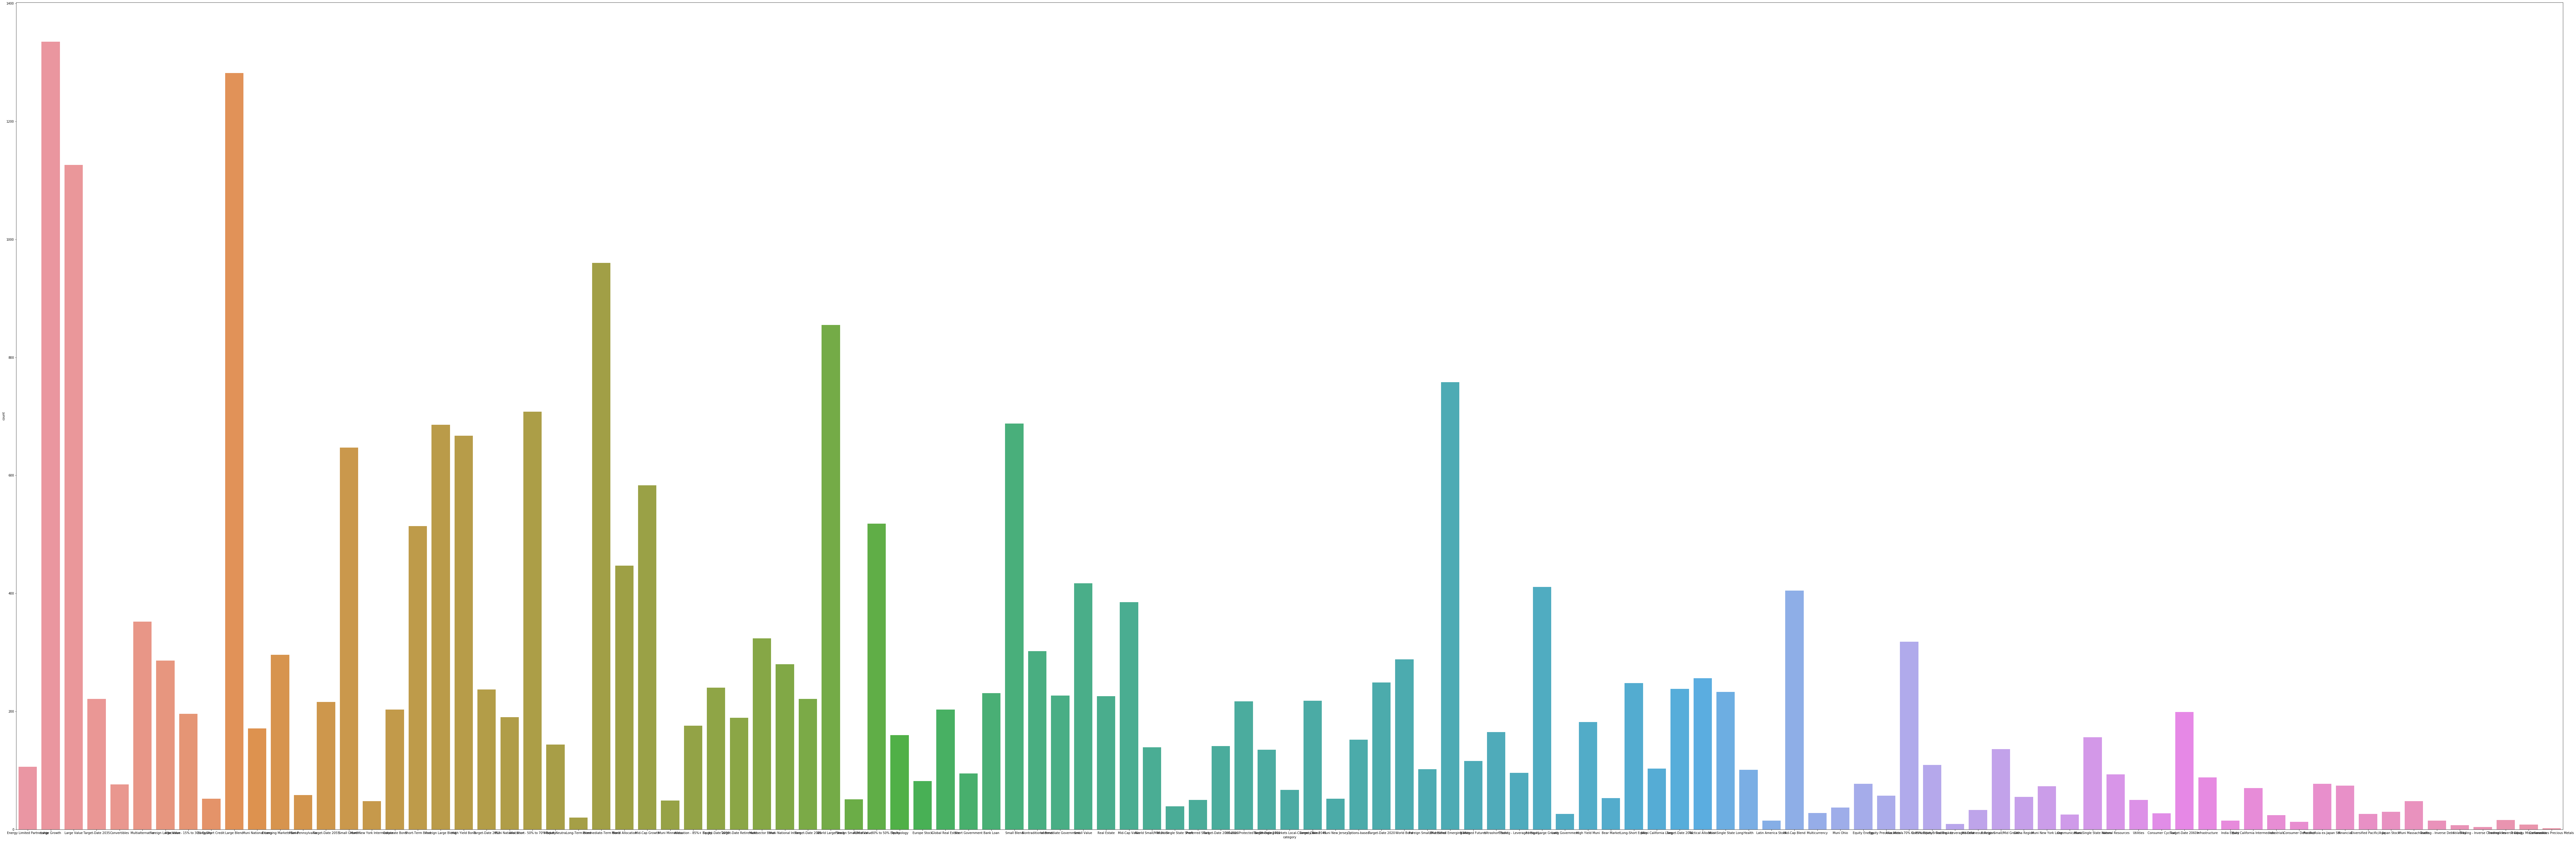

In [68]:
print(len(data.category.unique()))
#print(data.category.unique())
plt.figure(figsize=(150,50))
sns.countplot('category', data=data)
plt.show()

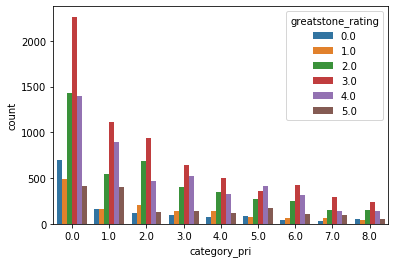

In [69]:
ax=sns.countplot('category_pri', hue='greatstone_rating', data=data)

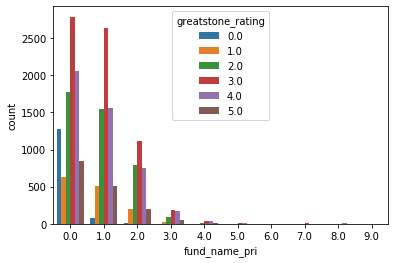

In [70]:
ax=sns.countplot('fund_name_pri',hue='greatstone_rating', data=data)

#### Split Dataset into train-set and test-set

In [71]:
train_set = df.loc[df['greatstone_rating'].notnull()]

In [72]:
test_set = df.loc[df['greatstone_rating'].isnull()]
test_set = test_set.drop('greatstone_rating', axis=1)

In [73]:
train_set = train_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

In [74]:
train_set.greatstone_rating = train_set.greatstone_rating.astype('int')
train_set.tag = train_set.tag.astype('int')
train_set.greatstone_rating.unique()

array([3, 4, 0, 5, 2, 1], dtype=int64)

In [75]:
train_set.shape, test_set.shape

((20000, 99), (5000, 98))

In [76]:
X = train_set.drop(['fund_id','greatstone_rating'],axis=1)
y = train_set['greatstone_rating']

In [77]:
X.shape, y.shape

((20000, 97), (20000,))

## LDA

In [78]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X, y)

In [79]:
#variance explained by each component.
lda.explained_variance_ratio_

array([8.40351867e-01, 1.49438886e-01, 6.94972767e-03, 2.48718968e-03,
       7.72329043e-04])

In [80]:
len(lda.coef_), len(lda.coef_[0])

(6, 97)

In [81]:
lda.classes_

array([0, 1, 2, 3, 4, 5])

In [82]:
lda.get_params()

{'n_components': None,
 'priors': None,
 'shrinkage': None,
 'solver': 'svd',
 'store_covariance': False,
 'tol': 0.0001}

In [83]:
X_lda.shape

(20000, 5)

In [84]:
lda.score(X,y)

0.61265

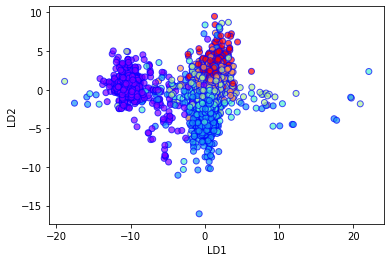

In [85]:
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)
plt.show()

## PCA

In [86]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X,y)

In [87]:
pca.explained_variance_ratio_

array([1.00000000e+00, 1.19886744e-11])

In [88]:
len(pca.components_), len(pca.components_[0] )

(2, 97)

In [89]:
pca.explained_variance_

array([3.60534459e+20, 4.32233024e+09])

In [90]:
pca.get_params()

{'copy': True,
 'iterated_power': 'auto',
 'n_components': 2,
 'random_state': None,
 'svd_solver': 'auto',
 'tol': 0.0,
 'whiten': False}

In [91]:
X_pca.shape

(20000, 2)

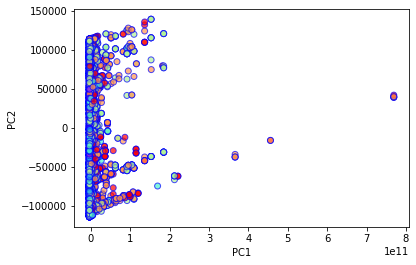

In [94]:
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.scatter(
    X_pca[:,0],
    X_pca[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)
plt.show()

## Model Building

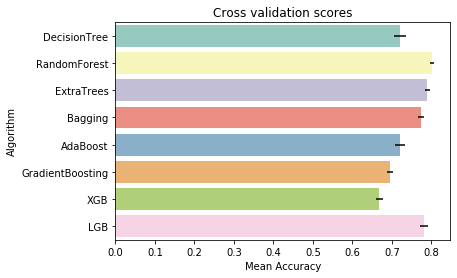

In [95]:
# Modeling step Test differents algorithms
random_state = 123
classifiers = []
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),
                                      random_state=random_state,learning_rate=0.1))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(xgb.XGBClassifier(random_state=random_state))
classifiers.append(lgb.LGBMClassifier(random_state=random_state))

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X, y, scoring = "accuracy", cv = kfold, n_jobs=4))
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["DecisionTree", "RandomForest",
                                                                                     "ExtraTrees","Bagging","AdaBoost",
                                                                                      "GradientBoosting","XGB","LGB"]})
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")


In [96]:
cv_res

CrossValMeans  CrossValerrors         Algorithm
0        0.71930        0.015173      DecisionTree
1        0.80165        0.005749      RandomForest
2        0.78980        0.007125        ExtraTrees
3        0.77330        0.007366           Bagging
4        0.72015        0.012635          AdaBoost
5        0.69565        0.008143  GradientBoosting
6        0.66815        0.008106               XGB
7        0.78140        0.009478               LGB

In [119]:
#Split features and labels into Train and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)
#X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.1)

In [121]:
#X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [113]:
#Scale X_train and X_test using zscore
X_trainZ = zscore(X_train)
X_testZ = zscore(X_test)

In [114]:
sscaler = StandardScaler()
X_trainS = sscaler.fit_transform(X_train)
X_testS = sscaler.transform(X_test)

In [115]:
normalizer = Normalizer()
X_trainN = normalizer.fit_transform(X_train)
X_testN = normalizer.transform(X_test)

In [116]:
from bayes_opt import BayesianOptimization

In [122]:
categorical_features = ['category_beta_3years','3_years_alpha_category','3_years_return_mean_annual_category','3yrs_sharpe_ratio_category','5_years_beta_category','5_years_alpha_category','5yrs_sharpe_ratio_category','5_years_return_mean_annual_category','10_years_alpha_category','10_years_beta_category','10yrs_sharpe_ratio_category','10_years_return_mean_annual_category', 'investment_class','fund_size', 'yrs_since_inception', 'fund_name_pri', 'category_pri']


In [262]:
def lgb_eval(num_leaves,max_depth,lambda_l2,lambda_l1,min_child_samples, min_data_in_leaf):
    params = {
    "objective" : "multiclass",
    "metric" : "multiclass", 
    'is_unbalance': True,
    "num_leaves" : int(num_leaves),
    "max_depth" : int(max_depth),
    "lambda_l2" : lambda_l2,
    "lambda_l1" : lambda_l1,
    "num_threads" : 20,
    "min_child_samples" : int(min_child_samples),
    'min_data_in_leaf': int(min_data_in_leaf),
    "learning_rate" : 0.03,
    "subsample_freq" : 5,
    "bagging_seed" : 42,
    "verbosity" : -1,
    "num_classes" : 6   
    }
    
    lgtrain = lgb.Dataset(X_train, y_train,categorical_feature=categorical_features)
    cv_result = lgb.cv(params,
                       lgtrain,
                       10000,
                       early_stopping_rounds=300,
                       stratified=True,
                       nfold=5)
    print(cv_result)
    return cv_result['multi_logloss-mean'][0]

In [263]:
def lgb_train(num_leaves,max_depth,lambda_l2,lambda_l1,min_child_samples, min_data_in_leaf):
    params = {
    "objective" : "multiclass",
    "metric" : "softmax", 
    'is_unbalance': True,
    "num_leaves" : int(num_leaves),
    "max_depth" : int(max_depth),
    "lambda_l2" : lambda_l2,
    "lambda_l1" : lambda_l1,
    "num_threads" : 20,
    "min_child_samples" : int(min_child_samples),
    'min_data_in_leaf': int(min_data_in_leaf),
    "learning_rate" : 0.03,
    "subsample_freq" : 5,
    "bagging_seed" : 42,
    "verbosity" : -1,
    "num_classes" : 6     
    }
    t_x,v_x,t_y,v_y = train_test_split(X_train, y_train,test_size=0.2)
    lgtrain = lgb.Dataset(t_x, t_y,categorical_feature=categorical_features)
    lgvalid = lgb.Dataset(v_x, v_y,categorical_feature=categorical_features)
    model = lgb.train(params, lgtrain, 4000, valid_sets=[lgvalid], early_stopping_rounds=400, verbose_eval=200)
    pred_test_y = model.predict(X_test, num_iteration=model.best_iteration)
    return pred_test_y, model
   

In [264]:
def param_tuning(init_points,num_iter,**args):
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (15, 200),
                                                'max_depth': (5, 63),
                                                'lambda_l2': (0.0, 5),
                                                'lambda_l1': (0.0, 5),
                                                'min_child_samples': (50, 5000),
                                                'min_data_in_leaf': (50, 300)
                                                })

    lgbBO.maximize(init_points=init_points, n_iter=num_iter,**args)
    return lgbBO

In [265]:
categorical_features = ['category_beta_3years','3_years_alpha_category','3_years_return_mean_annual_category','3yrs_sharpe_ratio_category','5_years_beta_category','5_years_alpha_category','5yrs_sharpe_ratio_category','5_years_return_mean_annual_category','10_years_alpha_category','10_years_beta_category','10yrs_sharpe_ratio_category','10_years_return_mean_annual_category', 'investment_class','fund_size', 'yrs_since_inception', 'fund_name_pri', 'category_pri']

In [ ]:
result = param_tuning(10,50)

|   iter    |  target   | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_da... | num_le... |
-------------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


{'multi_logloss-mean': [1.5799535229369779, 1.5569586274335692, 1.536103782696927, 1.5168872419622559, 1.4990942032792467, 1.4822257977203437, 1.466406033119599, 1.4512865666256265, 1.4369163204379245, 1.423256765809422, 1.410088291046602, 1.3976135175578692, 1.385642628372234, 1.3741437171790665, 1.362965111200074, 1.3521745159172707, 1.3416283181754955, 1.3315370814446703, 1.3216645516657295, 1.3122624173597022, 1.3030901896466198, 1.2942564023145364, 1.2856913878639649, 1.2773379037970725, 1.2690375216960565, 1.2611658324472832, 1.2534879221756967, 1.2458290090102544, 1.2385585448194416, 1.2312695366443733, 1.2241492237371099, 1.2173965811800578, 1.2108465075023616, 1.2041860665096429, 1.19773978582192, 1.1915052208584933, 1.1854984621700284, 1.1795541841414265, 1.1736672201602094, 1.1678166757758806, 1.162243405314484, 1.1567431725547805, 1.1512993802522664, 1.1460415692889934, 1.1409360029210174, 1.1358861755966307, 1.1308606690388856, 1.1259006350451854, 1.121065065045473, 1.1163

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


{'multi_logloss-mean': [1.578046517874451, 1.5533651435245475, 1.530967098196729, 1.5102710450107515, 1.4907510770949222, 1.4724421328853057, 1.4550547183135278, 1.4385289054369843, 1.4229939409769077, 1.407910283924624, 1.3935577123837692, 1.379950874932007, 1.366901243261505, 1.354331574276971, 1.3422962873362798, 1.330543607995112, 1.3193461830742157, 1.3082786768694645, 1.2976138796925838, 1.2872053120924776, 1.276945144416523, 1.267228751212579, 1.2579324581694404, 1.2490244085705196, 1.2400275983976368, 1.2314092898702658, 1.223241119437494, 1.215074490281756, 1.2070987720935862, 1.1993220795636286, 1.1918707733115181, 1.184682271134889, 1.1774696718921986, 1.1705606373187085, 1.1638166410492299, 1.1573153885278111, 1.1508472784652675, 1.1444139289339774, 1.1382815091465885, 1.1321175818772693, 1.1261658657530753, 1.120248569675437, 1.1145998257544707, 1.1091068361537368, 1.1035469606039858, 1.0979921035067377, 1.0927760317702904, 1.0875796280340606, 1.0825857514523824, 1.0776535

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


{'multi_logloss-mean': [1.5779979214666828, 1.5533345075840552, 1.5309038208689811, 1.5102145661045232, 1.4909505031879235, 1.4727653417177549, 1.455530138811922, 1.439161990200826, 1.4237202946844563, 1.4089970871461106, 1.3948424785133833, 1.3813551377955435, 1.3683953196357048, 1.355990724234872, 1.3439583283860013, 1.3322901699538245, 1.3210944830585447, 1.310268624232967, 1.2997840892025292, 1.2898372114841468, 1.280034022409971, 1.2706027077345816, 1.2614672452259896, 1.2525176553788568, 1.2439910768476459, 1.2355686124191565, 1.2272662869976199, 1.219236639418654, 1.2113350238835754, 1.2039244432994, 1.196367894880304, 1.1892866521682879, 1.1823517853173722, 1.1753176550199385, 1.1685293757692319, 1.1618747699595062, 1.1553770011777893, 1.1490580759940237, 1.1429509439227286, 1.1369718890841538, 1.1310103536642848, 1.125327751610133, 1.119638337119752, 1.1142763325537788, 1.1088500300824213, 1.1035814164357274, 1.0984341394011081, 1.0935168427382835, 1.0885742663163616, 1.083622

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


{'multi_logloss-mean': [1.5785076275225478, 1.554205201352136, 1.5323148279187522, 1.5118614859331716, 1.4929992016090163, 1.4752290134373163, 1.4582179155431336, 1.4421645383702724, 1.426964928800471, 1.4125204711113928, 1.39852837986089, 1.3853540325272131, 1.3726201135481184, 1.3602900132700257, 1.3484891011266185, 1.3370435337106397, 1.3261125791819492, 1.3154490854178982, 1.3049896667318348, 1.2950570341884269, 1.285002784358885, 1.2758107254820452, 1.266683388124029, 1.2578064875008563, 1.2492120974066705, 1.241033511482254, 1.2327072576233393, 1.2249833252193318, 1.2172384659038504, 1.2096310184053243, 1.2022084305683876, 1.1951600769527577, 1.18830909074353, 1.1813955910107177, 1.1747928269732464, 1.1682577583548803, 1.1619965031053048, 1.1557895154014284, 1.1498131957454465, 1.1438575148293815, 1.1381193167500894, 1.1325460091012074, 1.1268908175233283, 1.1215035862160512, 1.1162845730461215, 1.1111499541405117, 1.105980849228242, 1.101064249755202, 1.0962882873833968, 1.09165

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


{'multi_logloss-mean': [1.5804114033060603, 1.5579211586363804, 1.5376328587089836, 1.5190878894930975, 1.5016212700638967, 1.4852232426443641, 1.4697749109411427, 1.4550742679606399, 1.441049183898418, 1.427833718841852, 1.4151862589257962, 1.403122295502884, 1.3914860730171372, 1.3803616770185623, 1.3694992565210191, 1.3592697345712417, 1.3490896071847438, 1.3393299357861024, 1.3300108266621629, 1.3209977452642498, 1.3122025844975946, 1.3037667350876447, 1.2954278786449758, 1.2872424052962153, 1.279185163104154, 1.27164338655072, 1.2642625442944475, 1.257066832023319, 1.250015003380726, 1.2431649588031648, 1.2365937016399395, 1.2301091802770978, 1.223693104403998, 1.2173325624239726, 1.211301512271491, 1.205387671793614, 1.199527819263526, 1.1938286873404613, 1.188230911810144, 1.1829358929048488, 1.1777224944342604, 1.172622229905772, 1.1674234941105175, 1.1625745633907818, 1.157709258054692, 1.1528982904231888, 1.1482041565254033, 1.1436120484007806, 1.1391135584298013, 1.134715847

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


{'multi_logloss-mean': [1.574799682934182, 1.5471896886711705, 1.5222777108397945, 1.4993535868053438, 1.4777262079960856, 1.45778287847375, 1.4387817688949203, 1.4204020463575566, 1.4030401986871603, 1.3868070230703309, 1.3714174665315015, 1.3566047096301954, 1.342452162735337, 1.3288889196283808, 1.3159709929992456, 1.3034699250730477, 1.2914552652642581, 1.2796138476492875, 1.268302738587946, 1.257490666905492, 1.246794646160846, 1.236372449438314, 1.2261195694522913, 1.216388183136696, 1.2068706902965622, 1.1977421879886996, 1.1888787340120992, 1.1800906742145032, 1.1716747279749296, 1.1635499588824079, 1.1557583448303974, 1.1479192590003735, 1.140358240195604, 1.1329329931621266, 1.1257242522549142, 1.1186369663596385, 1.1117282665556192, 1.1048315225412506, 1.0982333962325403, 1.0916485399895357, 1.0853909329405558, 1.0792420847147959, 1.073207940331713, 1.067262102494957, 1.061558326339005, 1.055836608421056, 1.0504976635502543, 1.044985755080233, 1.039831422951431, 1.0346476367

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


{'multi_logloss-mean': [1.5741944718572713, 1.5466054679316845, 1.5213750375630242, 1.4980988452013242, 1.4762053101168708, 1.4557804212574053, 1.4364699902013522, 1.4180169699051546, 1.4004872193255908, 1.38401860294912, 1.3679205780076344, 1.3527017348857124, 1.3381575326550892, 1.3241781489413462, 1.310883591464541, 1.2979867365929199, 1.2856618127609256, 1.273779389456718, 1.2622481617804282, 1.2510229701438982, 1.2400122311643074, 1.229341530466309, 1.2191977200589905, 1.2091046196754978, 1.1994088277674073, 1.1900545843941424, 1.181040431322047, 1.1721644633115171, 1.163592949970539, 1.1552193048140424, 1.147033907836167, 1.1390982254065611, 1.1312312863592093, 1.1237928272340718, 1.116296260238123, 1.1088387721221407, 1.10179268317357, 1.0948617955930693, 1.0883995931774826, 1.0818419794044574, 1.0754300194702942, 1.069315616340384, 1.0632731005425324, 1.0573098356102273, 1.0515892736169739, 1.0459282825841307, 1.040313678835081, 1.0348695858057586, 1.0293594550990837, 1.0241159

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


{'multi_logloss-mean': [1.5775060737848445, 1.5524055263763044, 1.5296945819112007, 1.5085173194051367, 1.488666381166111, 1.4701163053739392, 1.4525447470399757, 1.4358183497590533, 1.4202645802890568, 1.4052878462585243, 1.3910578319059026, 1.3772607943370474, 1.364074394688518, 1.3514470272064825, 1.3394355396783824, 1.3278073403813635, 1.3164163981651238, 1.3054908208360814, 1.294847412507935, 1.2846575328665055, 1.2746396862349296, 1.264871533778185, 1.2554921391920135, 1.2463868773291338, 1.2374649889290148, 1.228967263609799, 1.2204856032374196, 1.2124258027478492, 1.204623883269278, 1.1970417754837341, 1.1893971273070356, 1.1820522306172727, 1.1749837928805007, 1.1678047336369741, 1.1609746115665815, 1.1543242744277715, 1.1478313704985028, 1.1414337816643043, 1.1353347497862427, 1.1291357352301397, 1.1231888242534949, 1.1172431510520908, 1.111590172432964, 1.106025971912807, 1.10055805448787, 1.0953265446779914, 1.0901594539353767, 1.0849772101968607, 1.0799490306909416, 1.0749

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


{'multi_logloss-mean': [1.5796497863030339, 1.5566598047542815, 1.5357787370033051, 1.516498679046839, 1.4985810217133173, 1.4817880267659056, 1.4656066378945902, 1.4503905800280552, 1.435934748809126, 1.4222106435818975, 1.4089723528423685, 1.3965022530920084, 1.384410936244136, 1.3727666958860625, 1.3615103397665629, 1.35068516540805, 1.3401956998765816, 1.3298520243050358, 1.3200913097171476, 1.310355742654925, 1.3009297892760625, 1.2918689736189513, 1.2832372737379802, 1.2748509776314643, 1.2665392337830244, 1.258385510218362, 1.2507187966177262, 1.2430231457487124, 1.2356550833417763, 1.2282524314599583, 1.2210746978963083, 1.2143647808640785, 1.2077696876556754, 1.2012781874520926, 1.1948960361381264, 1.188611626454866, 1.1824169654681886, 1.1765834488278577, 1.170743363714715, 1.165067722363324, 1.1594160190658012, 1.1539472540202858, 1.1485957868101093, 1.143302875690432, 1.1381764411940507, 1.1331547230095693, 1.1282516703457852, 1.1234777539073566, 1.1186275962709291, 1.11388

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


{'multi_logloss-mean': [1.572689419464313, 1.5437598457172095, 1.517124011685324, 1.4922331396378201, 1.4692720021481056, 1.4475470136301216, 1.4269894828139291, 1.4073785565289714, 1.3887468581673987, 1.3713797804553791, 1.354637371054277, 1.3385832338153822, 1.3232443200539072, 1.3085758654429445, 1.294357274590158, 1.2805055225124955, 1.2673410758707173, 1.2546864861785492, 1.2423393008388497, 1.2303616583985957, 1.2188932446216059, 1.2075708863015495, 1.1966922547970036, 1.1861119249453351, 1.1757263600640755, 1.1658056161834869, 1.155916716783524, 1.146402398503867, 1.1372114703720146, 1.1284709393871535, 1.1197159289508296, 1.1113192736985487, 1.1032543997769049, 1.095271027571272, 1.08750934104286, 1.0800098968401926, 1.072667806039875, 1.0655860556079981, 1.0583923257855863, 1.0515264665355162, 1.044872191770192, 1.0382740442651301, 1.031864970546127, 1.0256887802485692, 1.01943781062051, 1.0135307155071636, 1.0073834124231087, 1.0015998495430367, 0.9959867090818284, 0.99061187

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


{'multi_logloss-mean': [1.5799596374489202, 1.557207847124713, 1.5366153395910431, 1.5176984050425872, 1.5000480622146322, 1.483385463149853, 1.4679578814184462, 1.453062591035109, 1.4390293529050897, 1.4256209553072743, 1.412925219290548, 1.4007310791895708, 1.3890723969982708, 1.3779550145677777, 1.3670374558909573, 1.3566496648980508, 1.3466105892769384, 1.3369032886414192, 1.3276549650716816, 1.3184001748598062, 1.3096583385527931, 1.3010591937828004, 1.2927309899773292, 1.2845451464621442, 1.2766654673062352, 1.26887852011599, 1.2614478022758047, 1.2541994383801813, 1.24718539657419, 1.2400704571170487, 1.2334387952500194, 1.2269327476216607, 1.2206536683102827, 1.2143923645644104, 1.208278056557866, 1.2022527892771566, 1.1963483067291742, 1.19049612561134, 1.1850207126046908, 1.179478010562147, 1.1741505701958992, 1.168975148374577, 1.16387630868717, 1.158956910948735, 1.154106743061248, 1.149242786418681, 1.1446426960007106, 1.1400841609567007, 1.1357144956173948, 1.131304958983

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


{'multi_logloss-mean': [1.578031055487468, 1.553554064201724, 1.5313230863580443, 1.511101990042985, 1.491840758971898, 1.4738860236668085, 1.4569127436998577, 1.4407263306388007, 1.4257015253985652, 1.4111704414064057, 1.3972703589500102, 1.3840132101066516, 1.3712374511806593, 1.3588070911316006, 1.3471387846370824, 1.3357748949301418, 1.3246866667008177, 1.3140518993858656, 1.303663459601683, 1.2936420287526464, 1.2839326024588527, 1.2744823987666214, 1.2654158444467467, 1.2565272183027762, 1.2478818389494497, 1.2397370859514762, 1.2314038252318764, 1.2234822664388911, 1.2156616983252468, 1.2081033007158477, 1.2006984532416998, 1.1935083738150705, 1.1864695162158934, 1.1795921753805234, 1.1728455148674515, 1.166068268478581, 1.1598278131510065, 1.15352968319024, 1.1475137744760966, 1.1414717215462467, 1.1357991386991524, 1.1301196735789465, 1.1244581587116524, 1.1190702570603257, 1.1137827026763591, 1.1085650865748569, 1.103343690352503, 1.0981998320130715, 1.0932255344269444, 1.088

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


{'multi_logloss-mean': [1.5799335197206879, 1.5571022190934563, 1.5366221413582384, 1.5176754361349607, 1.5000566690516577, 1.4835174852449775, 1.467806599374753, 1.4530156687420628, 1.4388509525645738, 1.4255076619396285, 1.412711437773773, 1.4003190150436826, 1.3885292345757168, 1.3773069137099565, 1.3662142688966896, 1.3558030050515937, 1.34557100569961, 1.335802408229251, 1.3263082074668062, 1.3171074942168859, 1.307936175674611, 1.299216359721448, 1.2906181103269239, 1.2823762237636893, 1.2743387848916714, 1.2667525964010398, 1.259099593530499, 1.2518089008055142, 1.2445627680228104, 1.237610879612382, 1.2308560593458555, 1.2242143902347427, 1.2178265611981522, 1.2113740381448705, 1.2053411439228827, 1.1992748218721931, 1.1932773114628732, 1.1875178230755665, 1.181801463176186, 1.176473438708037, 1.170997136138829, 1.1656433430666233, 1.1604448006434738, 1.1554258964054078, 1.1505893494075168, 1.1458311027986883, 1.141039665651658, 1.1363124628030183, 1.1316594691078015, 1.1270556

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


{'multi_logloss-mean': [1.5800025714541133, 1.5570118490583074, 1.5360212198139263, 1.516826455109144, 1.4988673521855602, 1.4819310831620922, 1.4659508786879603, 1.4508796609755816, 1.4363511954577717, 1.4227724046514814, 1.4094815698977576, 1.396915613042433, 1.3849184246718877, 1.3733037998531104, 1.3620514666887107, 1.3512286701066194, 1.3406117409036256, 1.3304126722387615, 1.3207371003038049, 1.3111680961602672, 1.301848690577829, 1.2930378787909036, 1.2841920861826177, 1.2757386534659105, 1.2675819153299732, 1.2595673680331594, 1.2518367425945804, 1.2441636872444246, 1.2365881771051832, 1.2293767547969905, 1.2222342401910908, 1.215234057463465, 1.208442924609018, 1.2020487414941474, 1.1955924412333743, 1.1893231977635375, 1.1832971793116998, 1.1773574714047403, 1.1714252981115716, 1.1656685579545834, 1.160076820540034, 1.1545430147629179, 1.1490530142168907, 1.1437331212985924, 1.138655568718263, 1.1332902684180983, 1.128158345075526, 1.1232537620984562, 1.1185589746664575, 1.11

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


{'multi_logloss-mean': [1.580460652155909, 1.55797797669991, 1.537857093073842, 1.5191402889187593, 1.501842229450404, 1.4853038622768886, 1.4697815748452085, 1.455021701092077, 1.4411044744501713, 1.4279516862408521, 1.4154559946976129, 1.4034150466619295, 1.3918138017453192, 1.380591897643929, 1.3700423129129242, 1.3597158691703568, 1.3496865562687872, 1.339948574192477, 1.3306230394101077, 1.3214755914603658, 1.3127159211652013, 1.3042219873772427, 1.2958715533682705, 1.2877217368873173, 1.279814903782275, 1.2722560467846802, 1.264834748278545, 1.2576879613538423, 1.250758408250047, 1.2438817494202838, 1.2372577382295566, 1.2307432896573074, 1.224380842652496, 1.2182963537766434, 1.2120429267704123, 1.2059410168430078, 1.2001757644100635, 1.194567729014118, 1.189094842132952, 1.183751948907705, 1.1785150701795806, 1.173360347419942, 1.1681866187314087, 1.1632642554154433, 1.158596768607745, 1.1537050293781586, 1.1489944071151879, 1.1445288496478578, 1.1400888147207733, 1.13584239456

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


{'multi_logloss-mean': [1.5799198853464311, 1.5569341642867935, 1.5362100793946847, 1.5172087322245342, 1.499404120828371, 1.482872049112728, 1.4672176410983564, 1.452165132046363, 1.4380269181995629, 1.4244391224245407, 1.4116120313430887, 1.3992102158535764, 1.387413703645807, 1.3759664589356508, 1.3650323671957778, 1.3542553788823508, 1.3439024291499262, 1.333935911230395, 1.324111003191495, 1.3146274512092477, 1.3055859300237564, 1.2966761503378623, 1.2881237988506058, 1.279893683552103, 1.2719497853030943, 1.2643026499340548, 1.2565206899536157, 1.2491280343007551, 1.2417922147599725, 1.2346203472245876, 1.2276726820958357, 1.220937222282533, 1.2144887922718643, 1.208054495477177, 1.2019102036282625, 1.1955979693191077, 1.1895953478495396, 1.183922476304576, 1.178082916713874, 1.1725207254157737, 1.1670866854188284, 1.161731483507595, 1.1565663262526171, 1.1513530534191747, 1.1463256191856022, 1.14139915076791, 1.1365147270571716, 1.1318014617682706, 1.12710457880993, 1.1223873037

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [141]:
params = result.max['params']
params

{'lambda_l1': 0.04226742525427152,
 'lambda_l2': 0.28650215164993387,
 'max_depth': 12.106511399592637,
 'min_child_samples': 62.11915245621666,
 'min_data_in_leaf': 57.85810938461803,
 'num_leaves': 23.57678158873174}

In [147]:
pred_test_y1, m = lgb_train(**params)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.99994
[400]	valid_0's auc: 0.999981
[600]	valid_0's auc: 0.999988
[800]	valid_0's auc: 0.999991
[1000]	valid_0's auc: 0.999993
[1200]	valid_0's auc: 0.999993
Early stopping, best iteration is:
[920]	valid_0's auc: 0.999993


In [157]:
p = m.predict(
    data = X_test,
    num_iteration=m.best_iteration,
    raw_score=False,
    pred_leaf=True,
    pred_contrib=False,
    data_has_header=False,
    is_reshape=True
)

In [152]:
pred_test_y1

array([0.99999891, 0.99999719, 0.99999817, ..., 0.99999887, 0.99999928,
       0.99999948])

### LGBClassifier

In [164]:
df.shape

(25000, 99)

In [176]:
#%% Split datasets
train = df.loc[df['greatstone_rating'].notnull()]
test = df.loc[df['greatstone_rating'].isnull()]

In [177]:
train.shape, test.shape

((20000, 99), (5000, 99))

In [180]:
#%% Prepare data
def prepLGB(data,
            classCol='',
            IDCol='',
            fDrop=[]):

        # Drop class column
        if classCol != '':
            labels = data[classCol]
            fDrop = fDrop + [classCol]
        else:
            labels = []

        if IDCol != '':
            IDs = data[IDCol]
        else:
            IDs = []

        if fDrop != []:
           data = data.drop(fDrop,
                            axis=1)

        # Create LGB mats
        lData = lgb.Dataset(data, label=labels,
                            free_raw_data=False,
                            feature_name=list(data.columns),
                            categorical_feature='auto')

        return lData, labels, IDs, data

In [193]:
# Specify columns to drop
fDrop = ['tag','fund_id']
#'greatstone_rating'
#'fund_id'

In [194]:
# Split training data in to training and validation sets.
# Validation set is used for early stopping.
trainData, validData = train_test_split(train,
                                        test_size=0.3,
                                        stratify=train.greatstone_rating)

In [195]:
trainData.shape, validData.shape

((14000, 99), (6000, 99))

In [196]:
# Prepare the data sets
trainDataL, trainLabels, trainIDs, trainData = prepLGB(trainData,
                                                 classCol='greatstone_rating',
                                                 IDCol='',
                                                 fDrop=fDrop)

validDataL, validLabels, validIDs, validData = prepLGB(validData,
                                                 classCol='greatstone_rating',
                                                 IDCol='',
                                                 fDrop=fDrop)

testDataL, _, _ , testData = prepLGB(test,
                                 classCol='greatstone_rating',
                                 IDCol='',
                                 fDrop=fDrop)

In [197]:
# Prepare data set using all the training data
allTrainDataL, allTrainLabels, _ , allTrainData = prepLGB(train,
                                                 classCol='greatstone_rating',
                                                 IDCol='',
                                                 fDrop=fDrop)

In [219]:
# Set params
# Scores ~0.784 (without tuning and early stopping)
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'multiclass',
          'nthread': 3, # Updated from nthread
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_classes' : 6,
          'metric' : 'multiclass'}

In [220]:
# Create parameters to search
gridParams = {
    'learning_rate': [0.005, 0.01, 0.015, 0.002],
    'n_estimators': [40],
    'num_leaves': [6,8,12,16],
    'boosting_type' : ['gbdt'],
    'objective' : ['multiclass'],
    'random_state' : [501], # Updated from 'seed'
    'colsample_bytree' : [0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    'metric' : ['multiclass'],
    'num_classes' : [6]
    }

In [221]:
# Create classifier to use. Note that parameters have to be input manually
# not as a dict!
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'multiclass',
          n_jobs = 3, # Updated from 'nthread'
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])


In [225]:
# To view the default model params:
mdl.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq', 'max_bin', 'scale_pos_weight'])

In [226]:
# Create the grid
grid = GridSearchCV(mdl, gridParams,
                    verbose=0,
                    cv=4,
                    n_jobs=2)

In [227]:
# Run the grid
grid.fit(allTrainData, allTrainLabels)

GridSearchCV(cv=4, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_bin=512,
                                      max_depth=-1, min_child_samples=5,
                                      min_child_weight=1, min_split_gain=0.5,
                                      n_estimators=100, n_jobs=3, num_leaves=31,
                                      objective='multiclass', random_state=None,
                                      reg_alpha=0.0, reg_lambda=...
                         'colsample_bytree': [0.65, 0.66],
                         'learning_rate': [0.005, 0.01, 0.015, 0.002],
                         'metric': ['multiclass'], 'n_estimators': [40],
                         'num_classes': [6], 'num_leaves': [6, 8, 12, 16],
                         'objecti

In [228]:
# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

{'boosting_type': 'gbdt', 'colsample_bytree': 0.65, 'learning_rate': 0.015, 'metric': 'multiclass', 'n_estimators': 40, 'num_classes': 6, 'num_leaves': 16, 'objective': 'multiclass', 'random_state': 501, 'reg_alpha': 1.2, 'reg_lambda': 1, 'subsample': 0.75}
0.44925000000000004


In [229]:
# Using parameters already set above, replace in the best from the grid search
params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate']
# params['max_bin'] = grid.best_params_['max_bin']
params['num_leaves'] = grid.best_params_['num_leaves']
params['reg_alpha'] = grid.best_params_['reg_alpha']
params['reg_lambda'] = grid.best_params_['reg_lambda']
params['subsample'] = grid.best_params_['subsample']
# params['subsample_for_bin'] = grid.best_params_['subsample_for_bin']

In [230]:
print('Fitting with params: ')
print(params)

Fitting with params: 
{'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'multiclass', 'nthread': 3, 'num_leaves': 16, 'learning_rate': 0.015, 'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 0.75, 'subsample_freq': 1, 'colsample_bytree': 0.65, 'reg_alpha': 1.2, 'reg_lambda': 1, 'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 5, 'scale_pos_weight': 1, 'num_classes': 6, 'metric': 'multiclass'}


Fitting model 5
Training until validation scores don't improve for 50 rounds
[4]	training's multi_logloss: 1.55368	valid_1's multi_logloss: 1.55619
[8]	training's multi_logloss: 1.51029	valid_1's multi_logloss: 1.51536
[12]	training's multi_logloss: 1.47284	valid_1's multi_logloss: 1.48018
[16]	training's multi_logloss: 1.43858	valid_1's multi_logloss: 1.44804
[20]	training's multi_logloss: 1.40716	valid_1's multi_logloss: 1.41873
[24]	training's multi_logloss: 1.3789	valid_1's multi_logloss: 1.39238
[28]	training's multi_logloss: 1.35321	valid_1's multi_logloss: 1.36851
[32]	training's multi_logloss: 1.32921	valid_1's multi_logloss: 1.3463
[36]	training's multi_logloss: 1.30668	valid_1's multi_logloss: 1.32552
[40]	training's multi_logloss: 1.2854	valid_1's multi_logloss: 1.30595
[44]	training's multi_logloss: 1.26568	valid_1's multi_logloss: 1.28776
[48]	training's multi_logloss: 1.24711	valid_1's multi_logloss: 1.27078
[52]	training's multi_logloss: 1.22915	valid_1's multi_logloss: 

[880]	training's multi_logloss: 0.526749	valid_1's multi_logloss: 0.680822
[884]	training's multi_logloss: 0.525814	valid_1's multi_logloss: 0.680248
[888]	training's multi_logloss: 0.524881	valid_1's multi_logloss: 0.679627
[892]	training's multi_logloss: 0.523905	valid_1's multi_logloss: 0.679036
[896]	training's multi_logloss: 0.522977	valid_1's multi_logloss: 0.678489
[900]	training's multi_logloss: 0.521986	valid_1's multi_logloss: 0.677863
[904]	training's multi_logloss: 0.521037	valid_1's multi_logloss: 0.677228
[908]	training's multi_logloss: 0.520105	valid_1's multi_logloss: 0.676636
[912]	training's multi_logloss: 0.519184	valid_1's multi_logloss: 0.676048
[916]	training's multi_logloss: 0.51823	valid_1's multi_logloss: 0.675433
[920]	training's multi_logloss: 0.517318	valid_1's multi_logloss: 0.674836
[924]	training's multi_logloss: 0.516401	valid_1's multi_logloss: 0.674335
[928]	training's multi_logloss: 0.515499	valid_1's multi_logloss: 0.673747
[932]	training's multi_log

[1748]	training's multi_logloss: 0.407671	valid_1's multi_logloss: 0.616155
[1752]	training's multi_logloss: 0.407372	valid_1's multi_logloss: 0.616016
[1756]	training's multi_logloss: 0.40704	valid_1's multi_logloss: 0.615845
[1760]	training's multi_logloss: 0.406742	valid_1's multi_logloss: 0.61566
[1764]	training's multi_logloss: 0.406489	valid_1's multi_logloss: 0.615523
[1768]	training's multi_logloss: 0.406179	valid_1's multi_logloss: 0.615345
[1772]	training's multi_logloss: 0.405893	valid_1's multi_logloss: 0.615186
[1776]	training's multi_logloss: 0.405601	valid_1's multi_logloss: 0.615024
[1780]	training's multi_logloss: 0.405279	valid_1's multi_logloss: 0.614887
[1784]	training's multi_logloss: 0.405029	valid_1's multi_logloss: 0.614781
[1788]	training's multi_logloss: 0.404752	valid_1's multi_logloss: 0.614711
[1792]	training's multi_logloss: 0.404481	valid_1's multi_logloss: 0.614567
[1796]	training's multi_logloss: 0.404218	valid_1's multi_logloss: 0.614445
[1800]	trainin

[2184]	training's multi_logloss: 0.383281	valid_1's multi_logloss: 0.605368
[2188]	training's multi_logloss: 0.383097	valid_1's multi_logloss: 0.60529
[2192]	training's multi_logloss: 0.382937	valid_1's multi_logloss: 0.605219
[2196]	training's multi_logloss: 0.382778	valid_1's multi_logloss: 0.605155
[2200]	training's multi_logloss: 0.382534	valid_1's multi_logloss: 0.605072
[2204]	training's multi_logloss: 0.382374	valid_1's multi_logloss: 0.604993
[2208]	training's multi_logloss: 0.382175	valid_1's multi_logloss: 0.604907
[2212]	training's multi_logloss: 0.381966	valid_1's multi_logloss: 0.604834
[2216]	training's multi_logloss: 0.381798	valid_1's multi_logloss: 0.604777
[2220]	training's multi_logloss: 0.381686	valid_1's multi_logloss: 0.604722
[2224]	training's multi_logloss: 0.381494	valid_1's multi_logloss: 0.604652
[2228]	training's multi_logloss: 0.381358	valid_1's multi_logloss: 0.604602
[2232]	training's multi_logloss: 0.38116	valid_1's multi_logloss: 0.604552
[2236]	trainin

[2620]	training's multi_logloss: 0.368035	valid_1's multi_logloss: 0.599209
[2624]	training's multi_logloss: 0.367904	valid_1's multi_logloss: 0.599185
[2628]	training's multi_logloss: 0.367823	valid_1's multi_logloss: 0.599121
[2632]	training's multi_logloss: 0.367693	valid_1's multi_logloss: 0.599094
[2636]	training's multi_logloss: 0.367592	valid_1's multi_logloss: 0.599046
[2640]	training's multi_logloss: 0.367483	valid_1's multi_logloss: 0.59899
[2644]	training's multi_logloss: 0.367361	valid_1's multi_logloss: 0.598933
[2648]	training's multi_logloss: 0.367255	valid_1's multi_logloss: 0.598873
[2652]	training's multi_logloss: 0.367129	valid_1's multi_logloss: 0.598833
[2656]	training's multi_logloss: 0.366991	valid_1's multi_logloss: 0.598782
[2660]	training's multi_logloss: 0.366855	valid_1's multi_logloss: 0.598739
[2664]	training's multi_logloss: 0.36677	valid_1's multi_logloss: 0.598697
[2668]	training's multi_logloss: 0.366683	valid_1's multi_logloss: 0.598663
[2672]	trainin

[3060]	training's multi_logloss: 0.356984	valid_1's multi_logloss: 0.595029
[3064]	training's multi_logloss: 0.356907	valid_1's multi_logloss: 0.595018
[3068]	training's multi_logloss: 0.356822	valid_1's multi_logloss: 0.594955
[3072]	training's multi_logloss: 0.356733	valid_1's multi_logloss: 0.594905
[3076]	training's multi_logloss: 0.356647	valid_1's multi_logloss: 0.594853
[3080]	training's multi_logloss: 0.356557	valid_1's multi_logloss: 0.594821
[3084]	training's multi_logloss: 0.356478	valid_1's multi_logloss: 0.59479
[3088]	training's multi_logloss: 0.356407	valid_1's multi_logloss: 0.594734
[3092]	training's multi_logloss: 0.356283	valid_1's multi_logloss: 0.594678
[3096]	training's multi_logloss: 0.356225	valid_1's multi_logloss: 0.594626
[3100]	training's multi_logloss: 0.356133	valid_1's multi_logloss: 0.594574
[3104]	training's multi_logloss: 0.356024	valid_1's multi_logloss: 0.594584
[3108]	training's multi_logloss: 0.355932	valid_1's multi_logloss: 0.594537
[3112]	traini

[3508]	training's multi_logloss: 0.348284	valid_1's multi_logloss: 0.591737
[3512]	training's multi_logloss: 0.348195	valid_1's multi_logloss: 0.5917
[3516]	training's multi_logloss: 0.348146	valid_1's multi_logloss: 0.591679
[3520]	training's multi_logloss: 0.348093	valid_1's multi_logloss: 0.591684
[3524]	training's multi_logloss: 0.348038	valid_1's multi_logloss: 0.591642
[3528]	training's multi_logloss: 0.347965	valid_1's multi_logloss: 0.591647
[3532]	training's multi_logloss: 0.347912	valid_1's multi_logloss: 0.591625
[3536]	training's multi_logloss: 0.34785	valid_1's multi_logloss: 0.591622
[3540]	training's multi_logloss: 0.347811	valid_1's multi_logloss: 0.591602
[3544]	training's multi_logloss: 0.347728	valid_1's multi_logloss: 0.591562
[3548]	training's multi_logloss: 0.34768	valid_1's multi_logloss: 0.591573
[3552]	training's multi_logloss: 0.347586	valid_1's multi_logloss: 0.59153
[3556]	training's multi_logloss: 0.347494	valid_1's multi_logloss: 0.591505
[3560]	training's

[3952]	training's multi_logloss: 0.341446	valid_1's multi_logloss: 0.589232
[3956]	training's multi_logloss: 0.3414	valid_1's multi_logloss: 0.589191
[3960]	training's multi_logloss: 0.341335	valid_1's multi_logloss: 0.589189
[3964]	training's multi_logloss: 0.341282	valid_1's multi_logloss: 0.589173
[3968]	training's multi_logloss: 0.341217	valid_1's multi_logloss: 0.589175
[3972]	training's multi_logloss: 0.341176	valid_1's multi_logloss: 0.58917
[3976]	training's multi_logloss: 0.341141	valid_1's multi_logloss: 0.58914
[3980]	training's multi_logloss: 0.34107	valid_1's multi_logloss: 0.589116
[3984]	training's multi_logloss: 0.341019	valid_1's multi_logloss: 0.589105
[3988]	training's multi_logloss: 0.340959	valid_1's multi_logloss: 0.58909
[3992]	training's multi_logloss: 0.3409	valid_1's multi_logloss: 0.589071
[3996]	training's multi_logloss: 0.340862	valid_1's multi_logloss: 0.589078
[4000]	training's multi_logloss: 0.340803	valid_1's multi_logloss: 0.589056
[4004]	training's mu

[4392]	training's multi_logloss: 0.335854	valid_1's multi_logloss: 0.58729
[4396]	training's multi_logloss: 0.335827	valid_1's multi_logloss: 0.587268
[4400]	training's multi_logloss: 0.335788	valid_1's multi_logloss: 0.587244
[4404]	training's multi_logloss: 0.335714	valid_1's multi_logloss: 0.58721
[4408]	training's multi_logloss: 0.335658	valid_1's multi_logloss: 0.587184
[4412]	training's multi_logloss: 0.335606	valid_1's multi_logloss: 0.587166
[4416]	training's multi_logloss: 0.335563	valid_1's multi_logloss: 0.587141
[4420]	training's multi_logloss: 0.335483	valid_1's multi_logloss: 0.587101
[4424]	training's multi_logloss: 0.335438	valid_1's multi_logloss: 0.587084
[4428]	training's multi_logloss: 0.335408	valid_1's multi_logloss: 0.587068
[4432]	training's multi_logloss: 0.335377	valid_1's multi_logloss: 0.587045
[4436]	training's multi_logloss: 0.335349	valid_1's multi_logloss: 0.587017
[4440]	training's multi_logloss: 0.33531	valid_1's multi_logloss: 0.587018
[4444]	training

[4832]	training's multi_logloss: 0.331217	valid_1's multi_logloss: 0.585666
[4836]	training's multi_logloss: 0.33116	valid_1's multi_logloss: 0.585654
[4840]	training's multi_logloss: 0.331124	valid_1's multi_logloss: 0.585653
[4844]	training's multi_logloss: 0.331088	valid_1's multi_logloss: 0.585653
[4848]	training's multi_logloss: 0.331052	valid_1's multi_logloss: 0.585632
[4852]	training's multi_logloss: 0.331021	valid_1's multi_logloss: 0.585624
[4856]	training's multi_logloss: 0.330988	valid_1's multi_logloss: 0.585617
[4860]	training's multi_logloss: 0.330955	valid_1's multi_logloss: 0.585606
[4864]	training's multi_logloss: 0.330924	valid_1's multi_logloss: 0.58559
[4868]	training's multi_logloss: 0.330862	valid_1's multi_logloss: 0.585562
[4872]	training's multi_logloss: 0.330838	valid_1's multi_logloss: 0.585552
[4876]	training's multi_logloss: 0.330791	valid_1's multi_logloss: 0.585548
[4880]	training's multi_logloss: 0.330737	valid_1's multi_logloss: 0.585541
[4884]	trainin

[5276]	training's multi_logloss: 0.32716	valid_1's multi_logloss: 0.58434
[5280]	training's multi_logloss: 0.327132	valid_1's multi_logloss: 0.584332
[5284]	training's multi_logloss: 0.327094	valid_1's multi_logloss: 0.58433
[5288]	training's multi_logloss: 0.327064	valid_1's multi_logloss: 0.584304
[5292]	training's multi_logloss: 0.327029	valid_1's multi_logloss: 0.584299
[5296]	training's multi_logloss: 0.326995	valid_1's multi_logloss: 0.584272
[5300]	training's multi_logloss: 0.32694	valid_1's multi_logloss: 0.584265
[5304]	training's multi_logloss: 0.326902	valid_1's multi_logloss: 0.584248
[5308]	training's multi_logloss: 0.32687	valid_1's multi_logloss: 0.584247
[5312]	training's multi_logloss: 0.32684	valid_1's multi_logloss: 0.584235
[5316]	training's multi_logloss: 0.326819	valid_1's multi_logloss: 0.584227
[5320]	training's multi_logloss: 0.326793	valid_1's multi_logloss: 0.584215
[5324]	training's multi_logloss: 0.326754	valid_1's multi_logloss: 0.584219
[5328]	training's 

[5724]	training's multi_logloss: 0.323489	valid_1's multi_logloss: 0.583152
[5728]	training's multi_logloss: 0.323453	valid_1's multi_logloss: 0.583155
[5732]	training's multi_logloss: 0.323429	valid_1's multi_logloss: 0.583141
[5736]	training's multi_logloss: 0.32341	valid_1's multi_logloss: 0.583156
[5740]	training's multi_logloss: 0.323372	valid_1's multi_logloss: 0.583161
[5744]	training's multi_logloss: 0.323341	valid_1's multi_logloss: 0.583147
[5748]	training's multi_logloss: 0.323312	valid_1's multi_logloss: 0.583129
[5752]	training's multi_logloss: 0.323277	valid_1's multi_logloss: 0.583102
[5756]	training's multi_logloss: 0.323235	valid_1's multi_logloss: 0.583086
[5760]	training's multi_logloss: 0.323202	valid_1's multi_logloss: 0.583098
[5764]	training's multi_logloss: 0.323167	valid_1's multi_logloss: 0.583081
[5768]	training's multi_logloss: 0.323147	valid_1's multi_logloss: 0.583077
[5772]	training's multi_logloss: 0.32312	valid_1's multi_logloss: 0.583061
[5776]	trainin

[6172]	training's multi_logloss: 0.320164	valid_1's multi_logloss: 0.582161
[6176]	training's multi_logloss: 0.320135	valid_1's multi_logloss: 0.58214
[6180]	training's multi_logloss: 0.320103	valid_1's multi_logloss: 0.582133
[6184]	training's multi_logloss: 0.320075	valid_1's multi_logloss: 0.582097
[6188]	training's multi_logloss: 0.320034	valid_1's multi_logloss: 0.582091
[6192]	training's multi_logloss: 0.320019	valid_1's multi_logloss: 0.582078
[6196]	training's multi_logloss: 0.31998	valid_1's multi_logloss: 0.582082
[6200]	training's multi_logloss: 0.31995	valid_1's multi_logloss: 0.582071
[6204]	training's multi_logloss: 0.31991	valid_1's multi_logloss: 0.582041
[6208]	training's multi_logloss: 0.319882	valid_1's multi_logloss: 0.582016
[6212]	training's multi_logloss: 0.319858	valid_1's multi_logloss: 0.582015
[6216]	training's multi_logloss: 0.319816	valid_1's multi_logloss: 0.582
[6220]	training's multi_logloss: 0.319777	valid_1's multi_logloss: 0.581985
[6224]	training's m

[6612]	training's multi_logloss: 0.317177	valid_1's multi_logloss: 0.58123
[6616]	training's multi_logloss: 0.317159	valid_1's multi_logloss: 0.581226
[6620]	training's multi_logloss: 0.317117	valid_1's multi_logloss: 0.581224
[6624]	training's multi_logloss: 0.317083	valid_1's multi_logloss: 0.581213
[6628]	training's multi_logloss: 0.317067	valid_1's multi_logloss: 0.581213
[6632]	training's multi_logloss: 0.317045	valid_1's multi_logloss: 0.581197
[6636]	training's multi_logloss: 0.317029	valid_1's multi_logloss: 0.581178
[6640]	training's multi_logloss: 0.317017	valid_1's multi_logloss: 0.581176
[6644]	training's multi_logloss: 0.316991	valid_1's multi_logloss: 0.581174
[6648]	training's multi_logloss: 0.31697	valid_1's multi_logloss: 0.581167
[6652]	training's multi_logloss: 0.316939	valid_1's multi_logloss: 0.581155
[6656]	training's multi_logloss: 0.31691	valid_1's multi_logloss: 0.58113
[6660]	training's multi_logloss: 0.316876	valid_1's multi_logloss: 0.581106
[6664]	training'

[7060]	training's multi_logloss: 0.314419	valid_1's multi_logloss: 0.58035
[7064]	training's multi_logloss: 0.314398	valid_1's multi_logloss: 0.580358
[7068]	training's multi_logloss: 0.314376	valid_1's multi_logloss: 0.580372
[7072]	training's multi_logloss: 0.314359	valid_1's multi_logloss: 0.580373
[7076]	training's multi_logloss: 0.314323	valid_1's multi_logloss: 0.580352
[7080]	training's multi_logloss: 0.314295	valid_1's multi_logloss: 0.580356
[7084]	training's multi_logloss: 0.314271	valid_1's multi_logloss: 0.580365
[7088]	training's multi_logloss: 0.314252	valid_1's multi_logloss: 0.580357
[7092]	training's multi_logloss: 0.31423	valid_1's multi_logloss: 0.580362
[7096]	training's multi_logloss: 0.314198	valid_1's multi_logloss: 0.580352
[7100]	training's multi_logloss: 0.314187	valid_1's multi_logloss: 0.580352
[7104]	training's multi_logloss: 0.31416	valid_1's multi_logloss: 0.580355
[7108]	training's multi_logloss: 0.314127	valid_1's multi_logloss: 0.580351
[7112]	training

[7508]	training's multi_logloss: 0.31187	valid_1's multi_logloss: 0.579678
[7512]	training's multi_logloss: 0.311851	valid_1's multi_logloss: 0.579665
[7516]	training's multi_logloss: 0.311826	valid_1's multi_logloss: 0.579669
[7520]	training's multi_logloss: 0.311806	valid_1's multi_logloss: 0.579652
[7524]	training's multi_logloss: 0.311783	valid_1's multi_logloss: 0.579643
[7528]	training's multi_logloss: 0.311762	valid_1's multi_logloss: 0.57962
[7532]	training's multi_logloss: 0.311743	valid_1's multi_logloss: 0.579629
[7536]	training's multi_logloss: 0.311724	valid_1's multi_logloss: 0.579627
[7540]	training's multi_logloss: 0.311688	valid_1's multi_logloss: 0.579604
[7544]	training's multi_logloss: 0.31165	valid_1's multi_logloss: 0.579597
[7548]	training's multi_logloss: 0.311625	valid_1's multi_logloss: 0.579579
[7552]	training's multi_logloss: 0.31159	valid_1's multi_logloss: 0.579586
[7556]	training's multi_logloss: 0.311575	valid_1's multi_logloss: 0.579588
[7560]	training'

[7944]	training's multi_logloss: 0.309491	valid_1's multi_logloss: 0.578961
[7948]	training's multi_logloss: 0.309482	valid_1's multi_logloss: 0.578961
[7952]	training's multi_logloss: 0.309456	valid_1's multi_logloss: 0.578955
[7956]	training's multi_logloss: 0.309435	valid_1's multi_logloss: 0.578952
[7960]	training's multi_logloss: 0.309425	valid_1's multi_logloss: 0.578941
[7964]	training's multi_logloss: 0.309407	valid_1's multi_logloss: 0.578926
[7968]	training's multi_logloss: 0.309394	valid_1's multi_logloss: 0.578924
[7972]	training's multi_logloss: 0.309386	valid_1's multi_logloss: 0.578913
[7976]	training's multi_logloss: 0.30937	valid_1's multi_logloss: 0.578896
[7980]	training's multi_logloss: 0.309339	valid_1's multi_logloss: 0.578887
[7984]	training's multi_logloss: 0.309315	valid_1's multi_logloss: 0.578882
[7988]	training's multi_logloss: 0.3093	valid_1's multi_logloss: 0.578876
[7992]	training's multi_logloss: 0.309272	valid_1's multi_logloss: 0.578856
[7996]	training

[8392]	training's multi_logloss: 0.307455	valid_1's multi_logloss: 0.57827
[8396]	training's multi_logloss: 0.30742	valid_1's multi_logloss: 0.578253
[8400]	training's multi_logloss: 0.307399	valid_1's multi_logloss: 0.578252
[8404]	training's multi_logloss: 0.307382	valid_1's multi_logloss: 0.578235
[8408]	training's multi_logloss: 0.307357	valid_1's multi_logloss: 0.578233
[8412]	training's multi_logloss: 0.307347	valid_1's multi_logloss: 0.578238
[8416]	training's multi_logloss: 0.307336	valid_1's multi_logloss: 0.578244
[8420]	training's multi_logloss: 0.307319	valid_1's multi_logloss: 0.578243
[8424]	training's multi_logloss: 0.30729	valid_1's multi_logloss: 0.578246
[8428]	training's multi_logloss: 0.30727	valid_1's multi_logloss: 0.578251
[8432]	training's multi_logloss: 0.307256	valid_1's multi_logloss: 0.578261
[8436]	training's multi_logloss: 0.30724	valid_1's multi_logloss: 0.578249
[8440]	training's multi_logloss: 0.307224	valid_1's multi_logloss: 0.57824
[8444]	training's 

[8836]	training's multi_logloss: 0.305408	valid_1's multi_logloss: 0.577593
[8840]	training's multi_logloss: 0.305396	valid_1's multi_logloss: 0.577592
[8844]	training's multi_logloss: 0.305382	valid_1's multi_logloss: 0.577599
[8848]	training's multi_logloss: 0.305372	valid_1's multi_logloss: 0.5776
[8852]	training's multi_logloss: 0.305344	valid_1's multi_logloss: 0.577597
[8856]	training's multi_logloss: 0.30532	valid_1's multi_logloss: 0.577582
[8860]	training's multi_logloss: 0.305312	valid_1's multi_logloss: 0.577583
[8864]	training's multi_logloss: 0.305294	valid_1's multi_logloss: 0.577581
[8868]	training's multi_logloss: 0.305273	valid_1's multi_logloss: 0.577574
[8872]	training's multi_logloss: 0.305258	valid_1's multi_logloss: 0.577557
[8876]	training's multi_logloss: 0.305248	valid_1's multi_logloss: 0.577561
[8880]	training's multi_logloss: 0.305225	valid_1's multi_logloss: 0.577566
[8884]	training's multi_logloss: 0.305214	valid_1's multi_logloss: 0.577561
[8888]	training

[9231]	training's multi_logloss: 0.303835	valid_1's multi_logloss: 0.577181


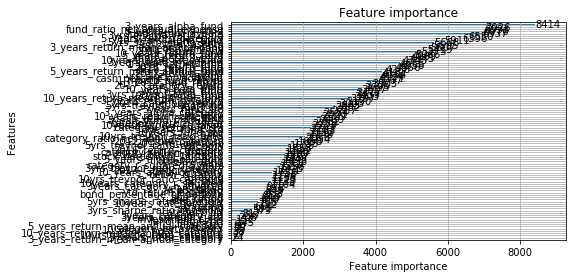

Fitting model 5
Training until validation scores don't improve for 50 rounds
[4]	training's multi_logloss: 1.55362	valid_1's multi_logloss: 1.55643
[8]	training's multi_logloss: 1.51071	valid_1's multi_logloss: 1.51621
[12]	training's multi_logloss: 1.47322	valid_1's multi_logloss: 1.48125
[16]	training's multi_logloss: 1.4393	valid_1's multi_logloss: 1.44964
[20]	training's multi_logloss: 1.40873	valid_1's multi_logloss: 1.42119
[24]	training's multi_logloss: 1.38087	valid_1's multi_logloss: 1.39554
[28]	training's multi_logloss: 1.35499	valid_1's multi_logloss: 1.37173
[32]	training's multi_logloss: 1.3305	valid_1's multi_logloss: 1.34904
[36]	training's multi_logloss: 1.30832	valid_1's multi_logloss: 1.32853
[40]	training's multi_logloss: 1.28674	valid_1's multi_logloss: 1.3089
[44]	training's multi_logloss: 1.26684	valid_1's multi_logloss: 1.29072
[48]	training's multi_logloss: 1.24834	valid_1's multi_logloss: 1.27375
[52]	training's multi_logloss: 1.23011	valid_1's multi_logloss: 

[888]	training's multi_logloss: 0.521085	valid_1's multi_logloss: 0.676853
[892]	training's multi_logloss: 0.520092	valid_1's multi_logloss: 0.676257
[896]	training's multi_logloss: 0.51918	valid_1's multi_logloss: 0.675727
[900]	training's multi_logloss: 0.518228	valid_1's multi_logloss: 0.675133
[904]	training's multi_logloss: 0.517269	valid_1's multi_logloss: 0.674548
[908]	training's multi_logloss: 0.516301	valid_1's multi_logloss: 0.673885
[912]	training's multi_logloss: 0.515383	valid_1's multi_logloss: 0.673358
[916]	training's multi_logloss: 0.514445	valid_1's multi_logloss: 0.672826
[920]	training's multi_logloss: 0.513501	valid_1's multi_logloss: 0.672284
[924]	training's multi_logloss: 0.512584	valid_1's multi_logloss: 0.671771
[928]	training's multi_logloss: 0.511692	valid_1's multi_logloss: 0.67122
[932]	training's multi_logloss: 0.510755	valid_1's multi_logloss: 0.670701
[936]	training's multi_logloss: 0.509829	valid_1's multi_logloss: 0.670177
[940]	training's multi_logl

[1324]	training's multi_logloss: 0.444971	valid_1's multi_logloss: 0.634918
[1328]	training's multi_logloss: 0.444499	valid_1's multi_logloss: 0.634641
[1332]	training's multi_logloss: 0.444023	valid_1's multi_logloss: 0.634381
[1336]	training's multi_logloss: 0.443557	valid_1's multi_logloss: 0.63414
[1340]	training's multi_logloss: 0.443114	valid_1's multi_logloss: 0.633935
[1344]	training's multi_logloss: 0.442671	valid_1's multi_logloss: 0.633694
[1348]	training's multi_logloss: 0.442217	valid_1's multi_logloss: 0.63347
[1352]	training's multi_logloss: 0.441753	valid_1's multi_logloss: 0.633251
[1356]	training's multi_logloss: 0.441322	valid_1's multi_logloss: 0.633069
[1360]	training's multi_logloss: 0.44085	valid_1's multi_logloss: 0.632842
[1364]	training's multi_logloss: 0.440399	valid_1's multi_logloss: 0.632619
[1368]	training's multi_logloss: 0.43987	valid_1's multi_logloss: 0.632383
[1372]	training's multi_logloss: 0.439432	valid_1's multi_logloss: 0.632221
[1376]	training'

[1768]	training's multi_logloss: 0.403624	valid_1's multi_logloss: 0.615734
[1772]	training's multi_logloss: 0.403323	valid_1's multi_logloss: 0.615597
[1776]	training's multi_logloss: 0.403054	valid_1's multi_logloss: 0.615467
[1780]	training's multi_logloss: 0.402769	valid_1's multi_logloss: 0.615359
[1784]	training's multi_logloss: 0.402484	valid_1's multi_logloss: 0.615221
[1788]	training's multi_logloss: 0.402218	valid_1's multi_logloss: 0.615108
[1792]	training's multi_logloss: 0.401998	valid_1's multi_logloss: 0.61505
[1796]	training's multi_logloss: 0.401747	valid_1's multi_logloss: 0.614962
[1800]	training's multi_logloss: 0.401444	valid_1's multi_logloss: 0.614831
[1804]	training's multi_logloss: 0.401145	valid_1's multi_logloss: 0.614734
[1808]	training's multi_logloss: 0.400914	valid_1's multi_logloss: 0.614632
[1812]	training's multi_logloss: 0.400654	valid_1's multi_logloss: 0.614539
[1816]	training's multi_logloss: 0.400406	valid_1's multi_logloss: 0.6144
[1820]	training

[2216]	training's multi_logloss: 0.379766	valid_1's multi_logloss: 0.606015
[2220]	training's multi_logloss: 0.379624	valid_1's multi_logloss: 0.605973
[2224]	training's multi_logloss: 0.379448	valid_1's multi_logloss: 0.605903
[2228]	training's multi_logloss: 0.379225	valid_1's multi_logloss: 0.605832
[2232]	training's multi_logloss: 0.379062	valid_1's multi_logloss: 0.605723
[2236]	training's multi_logloss: 0.37887	valid_1's multi_logloss: 0.605662
[2240]	training's multi_logloss: 0.378682	valid_1's multi_logloss: 0.605604
[2244]	training's multi_logloss: 0.378523	valid_1's multi_logloss: 0.60554
[2248]	training's multi_logloss: 0.378379	valid_1's multi_logloss: 0.605473
[2252]	training's multi_logloss: 0.378185	valid_1's multi_logloss: 0.605394
[2256]	training's multi_logloss: 0.37805	valid_1's multi_logloss: 0.605321
[2260]	training's multi_logloss: 0.377891	valid_1's multi_logloss: 0.605279
[2264]	training's multi_logloss: 0.37774	valid_1's multi_logloss: 0.60524
[2268]	training's

[2660]	training's multi_logloss: 0.36465	valid_1's multi_logloss: 0.60031
[2664]	training's multi_logloss: 0.364566	valid_1's multi_logloss: 0.600284
[2668]	training's multi_logloss: 0.364445	valid_1's multi_logloss: 0.600214
[2672]	training's multi_logloss: 0.364335	valid_1's multi_logloss: 0.600161
[2676]	training's multi_logloss: 0.364217	valid_1's multi_logloss: 0.600153
[2680]	training's multi_logloss: 0.364119	valid_1's multi_logloss: 0.600159
[2684]	training's multi_logloss: 0.36399	valid_1's multi_logloss: 0.600137
[2688]	training's multi_logloss: 0.363906	valid_1's multi_logloss: 0.600071
[2692]	training's multi_logloss: 0.363777	valid_1's multi_logloss: 0.599974
[2696]	training's multi_logloss: 0.363662	valid_1's multi_logloss: 0.599943
[2700]	training's multi_logloss: 0.363568	valid_1's multi_logloss: 0.599912
[2704]	training's multi_logloss: 0.363423	valid_1's multi_logloss: 0.599846
[2708]	training's multi_logloss: 0.363321	valid_1's multi_logloss: 0.59983
[2712]	training'

[3108]	training's multi_logloss: 0.353884	valid_1's multi_logloss: 0.596309
[3112]	training's multi_logloss: 0.353807	valid_1's multi_logloss: 0.596301
[3116]	training's multi_logloss: 0.353728	valid_1's multi_logloss: 0.596281
[3120]	training's multi_logloss: 0.353633	valid_1's multi_logloss: 0.596258
[3124]	training's multi_logloss: 0.353551	valid_1's multi_logloss: 0.596219
[3128]	training's multi_logloss: 0.353478	valid_1's multi_logloss: 0.596198
[3132]	training's multi_logloss: 0.353349	valid_1's multi_logloss: 0.596157
[3136]	training's multi_logloss: 0.353274	valid_1's multi_logloss: 0.596128
[3140]	training's multi_logloss: 0.353218	valid_1's multi_logloss: 0.596092
[3144]	training's multi_logloss: 0.353118	valid_1's multi_logloss: 0.596044
[3148]	training's multi_logloss: 0.353039	valid_1's multi_logloss: 0.596006
[3152]	training's multi_logloss: 0.352928	valid_1's multi_logloss: 0.595983
[3156]	training's multi_logloss: 0.352824	valid_1's multi_logloss: 0.595942
[3160]	train

[3556]	training's multi_logloss: 0.345604	valid_1's multi_logloss: 0.593537
[3560]	training's multi_logloss: 0.34554	valid_1's multi_logloss: 0.593502
[3564]	training's multi_logloss: 0.345489	valid_1's multi_logloss: 0.593461
[3568]	training's multi_logloss: 0.345429	valid_1's multi_logloss: 0.59345
[3572]	training's multi_logloss: 0.345379	valid_1's multi_logloss: 0.593445
[3576]	training's multi_logloss: 0.345307	valid_1's multi_logloss: 0.593414
[3580]	training's multi_logloss: 0.345237	valid_1's multi_logloss: 0.59338
[3584]	training's multi_logloss: 0.345177	valid_1's multi_logloss: 0.593391
[3588]	training's multi_logloss: 0.345126	valid_1's multi_logloss: 0.59338
[3592]	training's multi_logloss: 0.345062	valid_1's multi_logloss: 0.593332
[3596]	training's multi_logloss: 0.345016	valid_1's multi_logloss: 0.593314
[3600]	training's multi_logloss: 0.344969	valid_1's multi_logloss: 0.593302
[3604]	training's multi_logloss: 0.344891	valid_1's multi_logloss: 0.593276
[3608]	training'

[4004]	training's multi_logloss: 0.338875	valid_1's multi_logloss: 0.591684
[4008]	training's multi_logloss: 0.338829	valid_1's multi_logloss: 0.591668
[4012]	training's multi_logloss: 0.338779	valid_1's multi_logloss: 0.59165
[4016]	training's multi_logloss: 0.338726	valid_1's multi_logloss: 0.591645
[4020]	training's multi_logloss: 0.338672	valid_1's multi_logloss: 0.591618
[4024]	training's multi_logloss: 0.338639	valid_1's multi_logloss: 0.591594
[4028]	training's multi_logloss: 0.338592	valid_1's multi_logloss: 0.591575
[4032]	training's multi_logloss: 0.338528	valid_1's multi_logloss: 0.591544
[4036]	training's multi_logloss: 0.338476	valid_1's multi_logloss: 0.591506
[4040]	training's multi_logloss: 0.338424	valid_1's multi_logloss: 0.591472
[4044]	training's multi_logloss: 0.338367	valid_1's multi_logloss: 0.591446
[4048]	training's multi_logloss: 0.338327	valid_1's multi_logloss: 0.591432
[4052]	training's multi_logloss: 0.338269	valid_1's multi_logloss: 0.591389
[4056]	traini

[4440]	training's multi_logloss: 0.333669	valid_1's multi_logloss: 0.589857
[4444]	training's multi_logloss: 0.33362	valid_1's multi_logloss: 0.589833
[4448]	training's multi_logloss: 0.333566	valid_1's multi_logloss: 0.589827
[4452]	training's multi_logloss: 0.333527	valid_1's multi_logloss: 0.589809
[4456]	training's multi_logloss: 0.333483	valid_1's multi_logloss: 0.5898
[4460]	training's multi_logloss: 0.333421	valid_1's multi_logloss: 0.589789
[4464]	training's multi_logloss: 0.333387	valid_1's multi_logloss: 0.589771
[4468]	training's multi_logloss: 0.333322	valid_1's multi_logloss: 0.589726
[4472]	training's multi_logloss: 0.333284	valid_1's multi_logloss: 0.5897
[4476]	training's multi_logloss: 0.333233	valid_1's multi_logloss: 0.589692
[4480]	training's multi_logloss: 0.333185	valid_1's multi_logloss: 0.589686
[4484]	training's multi_logloss: 0.333127	valid_1's multi_logloss: 0.5897
[4488]	training's multi_logloss: 0.333072	valid_1's multi_logloss: 0.589677
[4492]	training's m

[4884]	training's multi_logloss: 0.329136	valid_1's multi_logloss: 0.588611
[4888]	training's multi_logloss: 0.32911	valid_1's multi_logloss: 0.588587
[4892]	training's multi_logloss: 0.329071	valid_1's multi_logloss: 0.58856
[4896]	training's multi_logloss: 0.329035	valid_1's multi_logloss: 0.588563
[4900]	training's multi_logloss: 0.329	valid_1's multi_logloss: 0.588549
[4904]	training's multi_logloss: 0.328961	valid_1's multi_logloss: 0.588526
[4908]	training's multi_logloss: 0.328927	valid_1's multi_logloss: 0.588521
[4912]	training's multi_logloss: 0.328909	valid_1's multi_logloss: 0.588512
[4916]	training's multi_logloss: 0.328861	valid_1's multi_logloss: 0.588517
[4920]	training's multi_logloss: 0.328829	valid_1's multi_logloss: 0.588512
[4924]	training's multi_logloss: 0.328776	valid_1's multi_logloss: 0.588485
[4928]	training's multi_logloss: 0.32874	valid_1's multi_logloss: 0.588471
[4932]	training's multi_logloss: 0.328692	valid_1's multi_logloss: 0.588452
[4936]	training's 

[5320]	training's multi_logloss: 0.325047	valid_1's multi_logloss: 0.58736
[5324]	training's multi_logloss: 0.325005	valid_1's multi_logloss: 0.587353
[5328]	training's multi_logloss: 0.324965	valid_1's multi_logloss: 0.58735
[5332]	training's multi_logloss: 0.324937	valid_1's multi_logloss: 0.587344
[5336]	training's multi_logloss: 0.324915	valid_1's multi_logloss: 0.587342
[5340]	training's multi_logloss: 0.324878	valid_1's multi_logloss: 0.587344
[5344]	training's multi_logloss: 0.324846	valid_1's multi_logloss: 0.587324
[5348]	training's multi_logloss: 0.324814	valid_1's multi_logloss: 0.587337
[5352]	training's multi_logloss: 0.324793	valid_1's multi_logloss: 0.58733
[5356]	training's multi_logloss: 0.324763	valid_1's multi_logloss: 0.587319
[5360]	training's multi_logloss: 0.324713	valid_1's multi_logloss: 0.587317
[5364]	training's multi_logloss: 0.324671	valid_1's multi_logloss: 0.587314
[5368]	training's multi_logloss: 0.324642	valid_1's multi_logloss: 0.587306
[5372]	training

[5760]	training's multi_logloss: 0.321466	valid_1's multi_logloss: 0.586534
[5764]	training's multi_logloss: 0.321429	valid_1's multi_logloss: 0.586533
[5768]	training's multi_logloss: 0.321406	valid_1's multi_logloss: 0.58653
[5772]	training's multi_logloss: 0.321381	valid_1's multi_logloss: 0.58652
[5776]	training's multi_logloss: 0.321344	valid_1's multi_logloss: 0.586501
[5780]	training's multi_logloss: 0.321323	valid_1's multi_logloss: 0.586493
[5784]	training's multi_logloss: 0.321307	valid_1's multi_logloss: 0.586487
[5788]	training's multi_logloss: 0.321266	valid_1's multi_logloss: 0.586465
[5792]	training's multi_logloss: 0.321216	valid_1's multi_logloss: 0.586452
[5796]	training's multi_logloss: 0.321181	valid_1's multi_logloss: 0.586446
[5800]	training's multi_logloss: 0.321154	valid_1's multi_logloss: 0.586451
[5804]	training's multi_logloss: 0.321127	valid_1's multi_logloss: 0.58644
[5808]	training's multi_logloss: 0.321101	valid_1's multi_logloss: 0.586457
[5812]	training

[6196]	training's multi_logloss: 0.318284	valid_1's multi_logloss: 0.585747
[6200]	training's multi_logloss: 0.318258	valid_1's multi_logloss: 0.585744
[6204]	training's multi_logloss: 0.31824	valid_1's multi_logloss: 0.585746
[6208]	training's multi_logloss: 0.318217	valid_1's multi_logloss: 0.585724
[6212]	training's multi_logloss: 0.318183	valid_1's multi_logloss: 0.58574
[6216]	training's multi_logloss: 0.318145	valid_1's multi_logloss: 0.58573
[6220]	training's multi_logloss: 0.318127	valid_1's multi_logloss: 0.585728
[6224]	training's multi_logloss: 0.318114	valid_1's multi_logloss: 0.585736
[6228]	training's multi_logloss: 0.318101	valid_1's multi_logloss: 0.585742
[6232]	training's multi_logloss: 0.318073	valid_1's multi_logloss: 0.58575
[6236]	training's multi_logloss: 0.318046	valid_1's multi_logloss: 0.58574
[6240]	training's multi_logloss: 0.318022	valid_1's multi_logloss: 0.585739
[6244]	training's multi_logloss: 0.317991	valid_1's multi_logloss: 0.585748
[6248]	training's

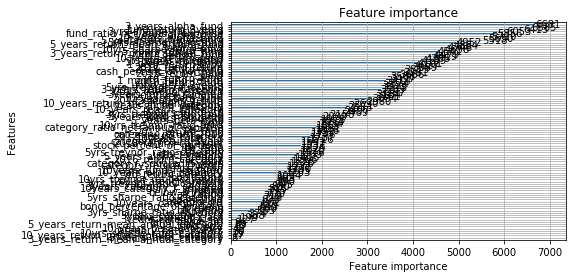

Fitting model 5
Training until validation scores don't improve for 50 rounds
[4]	training's multi_logloss: 1.55385	valid_1's multi_logloss: 1.55675
[8]	training's multi_logloss: 1.51098	valid_1's multi_logloss: 1.51669
[12]	training's multi_logloss: 1.47388	valid_1's multi_logloss: 1.48227
[16]	training's multi_logloss: 1.43979	valid_1's multi_logloss: 1.45091
[20]	training's multi_logloss: 1.4086	valid_1's multi_logloss: 1.42193
[24]	training's multi_logloss: 1.38046	valid_1's multi_logloss: 1.396
[28]	training's multi_logloss: 1.35452	valid_1's multi_logloss: 1.37202
[32]	training's multi_logloss: 1.33011	valid_1's multi_logloss: 1.34961
[36]	training's multi_logloss: 1.30729	valid_1's multi_logloss: 1.32883
[40]	training's multi_logloss: 1.28576	valid_1's multi_logloss: 1.30902
[44]	training's multi_logloss: 1.26581	valid_1's multi_logloss: 1.29083
[48]	training's multi_logloss: 1.24679	valid_1's multi_logloss: 1.27339
[52]	training's multi_logloss: 1.22869	valid_1's multi_logloss: 

[452]	training's multi_logloss: 0.680169	valid_1's multi_logloss: 0.792898
[456]	training's multi_logloss: 0.678033	valid_1's multi_logloss: 0.791394
[460]	training's multi_logloss: 0.675936	valid_1's multi_logloss: 0.789855
[464]	training's multi_logloss: 0.67383	valid_1's multi_logloss: 0.788288
[468]	training's multi_logloss: 0.671651	valid_1's multi_logloss: 0.786668
[472]	training's multi_logloss: 0.66958	valid_1's multi_logloss: 0.785195
[476]	training's multi_logloss: 0.667443	valid_1's multi_logloss: 0.783529
[480]	training's multi_logloss: 0.665511	valid_1's multi_logloss: 0.78218
[484]	training's multi_logloss: 0.663492	valid_1's multi_logloss: 0.780635
[488]	training's multi_logloss: 0.661569	valid_1's multi_logloss: 0.77925
[492]	training's multi_logloss: 0.659569	valid_1's multi_logloss: 0.777742
[496]	training's multi_logloss: 0.657644	valid_1's multi_logloss: 0.776368
[500]	training's multi_logloss: 0.655669	valid_1's multi_logloss: 0.774924
[504]	training's multi_loglos

[896]	training's multi_logloss: 0.521928	valid_1's multi_logloss: 0.685299
[900]	training's multi_logloss: 0.520917	valid_1's multi_logloss: 0.684687
[904]	training's multi_logloss: 0.519966	valid_1's multi_logloss: 0.68411
[908]	training's multi_logloss: 0.51905	valid_1's multi_logloss: 0.683527
[912]	training's multi_logloss: 0.518129	valid_1's multi_logloss: 0.682979
[916]	training's multi_logloss: 0.51716	valid_1's multi_logloss: 0.682403
[920]	training's multi_logloss: 0.516285	valid_1's multi_logloss: 0.681841
[924]	training's multi_logloss: 0.515352	valid_1's multi_logloss: 0.681278
[928]	training's multi_logloss: 0.514479	valid_1's multi_logloss: 0.680821
[932]	training's multi_logloss: 0.513569	valid_1's multi_logloss: 0.680313
[936]	training's multi_logloss: 0.512682	valid_1's multi_logloss: 0.679748
[940]	training's multi_logloss: 0.511785	valid_1's multi_logloss: 0.679227
[944]	training's multi_logloss: 0.510946	valid_1's multi_logloss: 0.678727
[948]	training's multi_loglo

[1776]	training's multi_logloss: 0.405981	valid_1's multi_logloss: 0.625893
[1780]	training's multi_logloss: 0.40573	valid_1's multi_logloss: 0.625765
[1784]	training's multi_logloss: 0.405441	valid_1's multi_logloss: 0.625634
[1788]	training's multi_logloss: 0.405184	valid_1's multi_logloss: 0.625564
[1792]	training's multi_logloss: 0.404868	valid_1's multi_logloss: 0.625458
[1796]	training's multi_logloss: 0.404579	valid_1's multi_logloss: 0.625333
[1800]	training's multi_logloss: 0.404325	valid_1's multi_logloss: 0.625217
[1804]	training's multi_logloss: 0.404067	valid_1's multi_logloss: 0.62509
[1808]	training's multi_logloss: 0.403812	valid_1's multi_logloss: 0.624989
[1812]	training's multi_logloss: 0.403565	valid_1's multi_logloss: 0.624885
[1816]	training's multi_logloss: 0.403313	valid_1's multi_logloss: 0.624734
[1820]	training's multi_logloss: 0.403032	valid_1's multi_logloss: 0.62463
[1824]	training's multi_logloss: 0.402786	valid_1's multi_logloss: 0.624555
[1828]	training

[2216]	training's multi_logloss: 0.382647	valid_1's multi_logloss: 0.616292
[2220]	training's multi_logloss: 0.38249	valid_1's multi_logloss: 0.616253
[2224]	training's multi_logloss: 0.382298	valid_1's multi_logloss: 0.616207
[2228]	training's multi_logloss: 0.382148	valid_1's multi_logloss: 0.616137
[2232]	training's multi_logloss: 0.381965	valid_1's multi_logloss: 0.616067
[2236]	training's multi_logloss: 0.381809	valid_1's multi_logloss: 0.615939
[2240]	training's multi_logloss: 0.381631	valid_1's multi_logloss: 0.61587
[2244]	training's multi_logloss: 0.381469	valid_1's multi_logloss: 0.615796
[2248]	training's multi_logloss: 0.381313	valid_1's multi_logloss: 0.615756
[2252]	training's multi_logloss: 0.381169	valid_1's multi_logloss: 0.615714
[2256]	training's multi_logloss: 0.381046	valid_1's multi_logloss: 0.615668
[2260]	training's multi_logloss: 0.38088	valid_1's multi_logloss: 0.615611
[2264]	training's multi_logloss: 0.38074	valid_1's multi_logloss: 0.615571
[2268]	training'

[2652]	training's multi_logloss: 0.3682	valid_1's multi_logloss: 0.610725
[2656]	training's multi_logloss: 0.368065	valid_1's multi_logloss: 0.610676
[2660]	training's multi_logloss: 0.367974	valid_1's multi_logloss: 0.610644
[2664]	training's multi_logloss: 0.367845	valid_1's multi_logloss: 0.610599
[2668]	training's multi_logloss: 0.36773	valid_1's multi_logloss: 0.610547
[2672]	training's multi_logloss: 0.367583	valid_1's multi_logloss: 0.610487
[2676]	training's multi_logloss: 0.367453	valid_1's multi_logloss: 0.610406
[2680]	training's multi_logloss: 0.367348	valid_1's multi_logloss: 0.610365
[2684]	training's multi_logloss: 0.367263	valid_1's multi_logloss: 0.610347
[2688]	training's multi_logloss: 0.367143	valid_1's multi_logloss: 0.610332
[2692]	training's multi_logloss: 0.367046	valid_1's multi_logloss: 0.610305
[2696]	training's multi_logloss: 0.36692	valid_1's multi_logloss: 0.610276
[2700]	training's multi_logloss: 0.366827	valid_1's multi_logloss: 0.610253
[2704]	training'

[3532]	training's multi_logloss: 0.349284	valid_1's multi_logloss: 0.603775
[3536]	training's multi_logloss: 0.349222	valid_1's multi_logloss: 0.603739
[3540]	training's multi_logloss: 0.349149	valid_1's multi_logloss: 0.603712
[3544]	training's multi_logloss: 0.349104	valid_1's multi_logloss: 0.603699
[3548]	training's multi_logloss: 0.349014	valid_1's multi_logloss: 0.603679
[3552]	training's multi_logloss: 0.348928	valid_1's multi_logloss: 0.603669
[3556]	training's multi_logloss: 0.348866	valid_1's multi_logloss: 0.603671
[3560]	training's multi_logloss: 0.348793	valid_1's multi_logloss: 0.603653
[3564]	training's multi_logloss: 0.348719	valid_1's multi_logloss: 0.603641
[3568]	training's multi_logloss: 0.34864	valid_1's multi_logloss: 0.6036
[3572]	training's multi_logloss: 0.348575	valid_1's multi_logloss: 0.603576
[3576]	training's multi_logloss: 0.348488	valid_1's multi_logloss: 0.603568
[3580]	training's multi_logloss: 0.348419	valid_1's multi_logloss: 0.603533
[3584]	training

[3980]	training's multi_logloss: 0.342493	valid_1's multi_logloss: 0.601296
[3984]	training's multi_logloss: 0.34243	valid_1's multi_logloss: 0.601267
[3988]	training's multi_logloss: 0.342363	valid_1's multi_logloss: 0.601223
[3992]	training's multi_logloss: 0.342329	valid_1's multi_logloss: 0.601206
[3996]	training's multi_logloss: 0.342291	valid_1's multi_logloss: 0.6012
[4000]	training's multi_logloss: 0.342238	valid_1's multi_logloss: 0.601183
[4004]	training's multi_logloss: 0.342161	valid_1's multi_logloss: 0.601192
[4008]	training's multi_logloss: 0.34212	valid_1's multi_logloss: 0.601156
[4012]	training's multi_logloss: 0.342052	valid_1's multi_logloss: 0.601131
[4016]	training's multi_logloss: 0.342016	valid_1's multi_logloss: 0.601109
[4020]	training's multi_logloss: 0.341957	valid_1's multi_logloss: 0.601084
[4024]	training's multi_logloss: 0.341899	valid_1's multi_logloss: 0.601056
[4028]	training's multi_logloss: 0.341866	valid_1's multi_logloss: 0.601054
[4032]	training'

[4416]	training's multi_logloss: 0.337002	valid_1's multi_logloss: 0.599496
[4420]	training's multi_logloss: 0.336957	valid_1's multi_logloss: 0.599497
[4424]	training's multi_logloss: 0.336919	valid_1's multi_logloss: 0.599463
[4428]	training's multi_logloss: 0.336889	valid_1's multi_logloss: 0.599464
[4432]	training's multi_logloss: 0.336824	valid_1's multi_logloss: 0.599448
[4436]	training's multi_logloss: 0.336781	valid_1's multi_logloss: 0.599442
[4440]	training's multi_logloss: 0.336756	valid_1's multi_logloss: 0.599435
[4444]	training's multi_logloss: 0.336696	valid_1's multi_logloss: 0.599401
[4448]	training's multi_logloss: 0.33664	valid_1's multi_logloss: 0.59937
[4452]	training's multi_logloss: 0.336606	valid_1's multi_logloss: 0.599347
[4456]	training's multi_logloss: 0.336558	valid_1's multi_logloss: 0.599349
[4460]	training's multi_logloss: 0.336513	valid_1's multi_logloss: 0.599323
[4464]	training's multi_logloss: 0.336469	valid_1's multi_logloss: 0.599316
[4468]	trainin

[4864]	training's multi_logloss: 0.332363	valid_1's multi_logloss: 0.598109
[4868]	training's multi_logloss: 0.332311	valid_1's multi_logloss: 0.598078
[4872]	training's multi_logloss: 0.332267	valid_1's multi_logloss: 0.598062
[4876]	training's multi_logloss: 0.332229	valid_1's multi_logloss: 0.598052
[4880]	training's multi_logloss: 0.332189	valid_1's multi_logloss: 0.598035
[4884]	training's multi_logloss: 0.332141	valid_1's multi_logloss: 0.598001
[4888]	training's multi_logloss: 0.33211	valid_1's multi_logloss: 0.597998
[4892]	training's multi_logloss: 0.332083	valid_1's multi_logloss: 0.597994
[4896]	training's multi_logloss: 0.332056	valid_1's multi_logloss: 0.597994
[4900]	training's multi_logloss: 0.332035	valid_1's multi_logloss: 0.597985
[4904]	training's multi_logloss: 0.332003	valid_1's multi_logloss: 0.597969
[4908]	training's multi_logloss: 0.33198	valid_1's multi_logloss: 0.597954
[4912]	training's multi_logloss: 0.331934	valid_1's multi_logloss: 0.59794
[4916]	training

[5300]	training's multi_logloss: 0.328481	valid_1's multi_logloss: 0.596689
[5304]	training's multi_logloss: 0.328454	valid_1's multi_logloss: 0.596689
[5308]	training's multi_logloss: 0.328429	valid_1's multi_logloss: 0.596681
[5312]	training's multi_logloss: 0.328391	valid_1's multi_logloss: 0.596677
[5316]	training's multi_logloss: 0.328331	valid_1's multi_logloss: 0.596634
[5320]	training's multi_logloss: 0.328306	valid_1's multi_logloss: 0.596633
[5324]	training's multi_logloss: 0.328287	valid_1's multi_logloss: 0.596622
[5328]	training's multi_logloss: 0.328255	valid_1's multi_logloss: 0.596605
[5332]	training's multi_logloss: 0.328234	valid_1's multi_logloss: 0.596573
[5336]	training's multi_logloss: 0.328211	valid_1's multi_logloss: 0.596562
[5340]	training's multi_logloss: 0.328179	valid_1's multi_logloss: 0.596563
[5344]	training's multi_logloss: 0.328147	valid_1's multi_logloss: 0.596548
[5348]	training's multi_logloss: 0.328102	valid_1's multi_logloss: 0.596552
[5352]	train

[5748]	training's multi_logloss: 0.324881	valid_1's multi_logloss: 0.595563
[5752]	training's multi_logloss: 0.32484	valid_1's multi_logloss: 0.595556
[5756]	training's multi_logloss: 0.324799	valid_1's multi_logloss: 0.595544
[5760]	training's multi_logloss: 0.324759	valid_1's multi_logloss: 0.595531
[5764]	training's multi_logloss: 0.324725	valid_1's multi_logloss: 0.595529
[5768]	training's multi_logloss: 0.324695	valid_1's multi_logloss: 0.595501
[5772]	training's multi_logloss: 0.324668	valid_1's multi_logloss: 0.595485
[5776]	training's multi_logloss: 0.324628	valid_1's multi_logloss: 0.595455
[5780]	training's multi_logloss: 0.32458	valid_1's multi_logloss: 0.595422
[5784]	training's multi_logloss: 0.324551	valid_1's multi_logloss: 0.595418
[5788]	training's multi_logloss: 0.324513	valid_1's multi_logloss: 0.595404
[5792]	training's multi_logloss: 0.324484	valid_1's multi_logloss: 0.595379
[5796]	training's multi_logloss: 0.324461	valid_1's multi_logloss: 0.595377
[5800]	trainin

[6192]	training's multi_logloss: 0.321511	valid_1's multi_logloss: 0.594353
[6196]	training's multi_logloss: 0.321478	valid_1's multi_logloss: 0.594338
[6200]	training's multi_logloss: 0.321456	valid_1's multi_logloss: 0.594328
[6204]	training's multi_logloss: 0.321427	valid_1's multi_logloss: 0.594296
[6208]	training's multi_logloss: 0.321397	valid_1's multi_logloss: 0.594291
[6212]	training's multi_logloss: 0.32137	valid_1's multi_logloss: 0.594289
[6216]	training's multi_logloss: 0.321342	valid_1's multi_logloss: 0.594273
[6220]	training's multi_logloss: 0.321313	valid_1's multi_logloss: 0.594262
[6224]	training's multi_logloss: 0.321282	valid_1's multi_logloss: 0.594257
[6228]	training's multi_logloss: 0.321245	valid_1's multi_logloss: 0.594247
[6232]	training's multi_logloss: 0.321211	valid_1's multi_logloss: 0.594249
[6236]	training's multi_logloss: 0.321186	valid_1's multi_logloss: 0.594249
[6240]	training's multi_logloss: 0.321154	valid_1's multi_logloss: 0.594239
[6244]	traini

[6640]	training's multi_logloss: 0.318603	valid_1's multi_logloss: 0.59346
[6644]	training's multi_logloss: 0.318563	valid_1's multi_logloss: 0.593439
[6648]	training's multi_logloss: 0.318547	valid_1's multi_logloss: 0.593439
[6652]	training's multi_logloss: 0.31851	valid_1's multi_logloss: 0.593432
[6656]	training's multi_logloss: 0.318475	valid_1's multi_logloss: 0.593437
[6660]	training's multi_logloss: 0.31845	valid_1's multi_logloss: 0.593454
[6664]	training's multi_logloss: 0.318426	valid_1's multi_logloss: 0.593453
[6668]	training's multi_logloss: 0.318403	valid_1's multi_logloss: 0.593463
[6672]	training's multi_logloss: 0.318374	valid_1's multi_logloss: 0.593439
[6676]	training's multi_logloss: 0.318362	valid_1's multi_logloss: 0.593434
[6680]	training's multi_logloss: 0.318351	valid_1's multi_logloss: 0.593432
[6684]	training's multi_logloss: 0.318314	valid_1's multi_logloss: 0.593421
[6688]	training's multi_logloss: 0.318282	valid_1's multi_logloss: 0.593396
[6692]	training

[7084]	training's multi_logloss: 0.315872	valid_1's multi_logloss: 0.592613
[7088]	training's multi_logloss: 0.315851	valid_1's multi_logloss: 0.592617
[7092]	training's multi_logloss: 0.315826	valid_1's multi_logloss: 0.592608
[7096]	training's multi_logloss: 0.315812	valid_1's multi_logloss: 0.592604
[7100]	training's multi_logloss: 0.315785	valid_1's multi_logloss: 0.592595
[7104]	training's multi_logloss: 0.315752	valid_1's multi_logloss: 0.592594
[7108]	training's multi_logloss: 0.315716	valid_1's multi_logloss: 0.592578
[7112]	training's multi_logloss: 0.315692	valid_1's multi_logloss: 0.592563
[7116]	training's multi_logloss: 0.315669	valid_1's multi_logloss: 0.59256
[7120]	training's multi_logloss: 0.315654	valid_1's multi_logloss: 0.592539
[7124]	training's multi_logloss: 0.315643	valid_1's multi_logloss: 0.592534
[7128]	training's multi_logloss: 0.315629	valid_1's multi_logloss: 0.592533
[7132]	training's multi_logloss: 0.315608	valid_1's multi_logloss: 0.592512
[7136]	traini

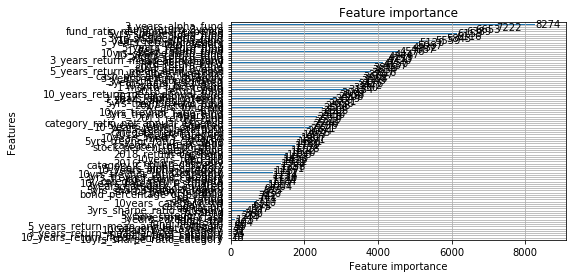

Fitting model 5
Training until validation scores don't improve for 50 rounds
[4]	training's multi_logloss: 1.55426	valid_1's multi_logloss: 1.55621
[8]	training's multi_logloss: 1.51173	valid_1's multi_logloss: 1.51571
[12]	training's multi_logloss: 1.47478	valid_1's multi_logloss: 1.48054
[16]	training's multi_logloss: 1.44081	valid_1's multi_logloss: 1.44858
[20]	training's multi_logloss: 1.41073	valid_1's multi_logloss: 1.42049
[24]	training's multi_logloss: 1.38358	valid_1's multi_logloss: 1.39519
[28]	training's multi_logloss: 1.35838	valid_1's multi_logloss: 1.37163
[32]	training's multi_logloss: 1.33428	valid_1's multi_logloss: 1.34941
[36]	training's multi_logloss: 1.31165	valid_1's multi_logloss: 1.32828
[40]	training's multi_logloss: 1.29034	valid_1's multi_logloss: 1.30862
[44]	training's multi_logloss: 1.2707	valid_1's multi_logloss: 1.29064
[48]	training's multi_logloss: 1.25185	valid_1's multi_logloss: 1.27318
[52]	training's multi_logloss: 1.23363	valid_1's multi_logloss

[452]	training's multi_logloss: 0.683797	valid_1's multi_logloss: 0.788269
[456]	training's multi_logloss: 0.681561	valid_1's multi_logloss: 0.786596
[460]	training's multi_logloss: 0.67955	valid_1's multi_logloss: 0.785139
[464]	training's multi_logloss: 0.677317	valid_1's multi_logloss: 0.783468
[468]	training's multi_logloss: 0.675287	valid_1's multi_logloss: 0.781952
[472]	training's multi_logloss: 0.673184	valid_1's multi_logloss: 0.780511
[476]	training's multi_logloss: 0.671111	valid_1's multi_logloss: 0.778935
[480]	training's multi_logloss: 0.668897	valid_1's multi_logloss: 0.777167
[484]	training's multi_logloss: 0.666874	valid_1's multi_logloss: 0.775767
[488]	training's multi_logloss: 0.664775	valid_1's multi_logloss: 0.774333
[492]	training's multi_logloss: 0.662878	valid_1's multi_logloss: 0.77298
[496]	training's multi_logloss: 0.660918	valid_1's multi_logloss: 0.771568
[500]	training's multi_logloss: 0.659041	valid_1's multi_logloss: 0.770224
[504]	training's multi_logl

[896]	training's multi_logloss: 0.524313	valid_1's multi_logloss: 0.679466
[900]	training's multi_logloss: 0.523352	valid_1's multi_logloss: 0.678865
[904]	training's multi_logloss: 0.522411	valid_1's multi_logloss: 0.678316
[908]	training's multi_logloss: 0.521509	valid_1's multi_logloss: 0.67779
[912]	training's multi_logloss: 0.520628	valid_1's multi_logloss: 0.677244
[916]	training's multi_logloss: 0.519739	valid_1's multi_logloss: 0.676738
[920]	training's multi_logloss: 0.518874	valid_1's multi_logloss: 0.676223
[924]	training's multi_logloss: 0.51795	valid_1's multi_logloss: 0.675566
[928]	training's multi_logloss: 0.51707	valid_1's multi_logloss: 0.675047
[932]	training's multi_logloss: 0.516219	valid_1's multi_logloss: 0.674604
[936]	training's multi_logloss: 0.515328	valid_1's multi_logloss: 0.674124
[940]	training's multi_logloss: 0.514442	valid_1's multi_logloss: 0.673622
[944]	training's multi_logloss: 0.513568	valid_1's multi_logloss: 0.673119
[948]	training's multi_loglo

[1340]	training's multi_logloss: 0.447471	valid_1's multi_logloss: 0.636848
[1344]	training's multi_logloss: 0.447035	valid_1's multi_logloss: 0.636674
[1348]	training's multi_logloss: 0.446517	valid_1's multi_logloss: 0.636372
[1352]	training's multi_logloss: 0.446031	valid_1's multi_logloss: 0.636124
[1356]	training's multi_logloss: 0.445581	valid_1's multi_logloss: 0.635909
[1360]	training's multi_logloss: 0.445096	valid_1's multi_logloss: 0.635653
[1364]	training's multi_logloss: 0.444639	valid_1's multi_logloss: 0.635446
[1368]	training's multi_logloss: 0.444162	valid_1's multi_logloss: 0.635274
[1372]	training's multi_logloss: 0.443688	valid_1's multi_logloss: 0.635032
[1376]	training's multi_logloss: 0.443204	valid_1's multi_logloss: 0.634746
[1380]	training's multi_logloss: 0.442745	valid_1's multi_logloss: 0.634455
[1384]	training's multi_logloss: 0.442294	valid_1's multi_logloss: 0.634246
[1388]	training's multi_logloss: 0.441855	valid_1's multi_logloss: 0.634028
[1392]	train

[1784]	training's multi_logloss: 0.406675	valid_1's multi_logloss: 0.617764
[1788]	training's multi_logloss: 0.406415	valid_1's multi_logloss: 0.617645
[1792]	training's multi_logloss: 0.406112	valid_1's multi_logloss: 0.617512
[1796]	training's multi_logloss: 0.405811	valid_1's multi_logloss: 0.617374
[1800]	training's multi_logloss: 0.405545	valid_1's multi_logloss: 0.617228
[1804]	training's multi_logloss: 0.405308	valid_1's multi_logloss: 0.617139
[1808]	training's multi_logloss: 0.404987	valid_1's multi_logloss: 0.617014
[1812]	training's multi_logloss: 0.404712	valid_1's multi_logloss: 0.616899
[1816]	training's multi_logloss: 0.404451	valid_1's multi_logloss: 0.616826
[1820]	training's multi_logloss: 0.404237	valid_1's multi_logloss: 0.61674
[1824]	training's multi_logloss: 0.403991	valid_1's multi_logloss: 0.61665
[1828]	training's multi_logloss: 0.403726	valid_1's multi_logloss: 0.616531
[1832]	training's multi_logloss: 0.403468	valid_1's multi_logloss: 0.616427
[1836]	trainin

[2232]	training's multi_logloss: 0.382062	valid_1's multi_logloss: 0.607468
[2236]	training's multi_logloss: 0.381942	valid_1's multi_logloss: 0.607395
[2240]	training's multi_logloss: 0.381786	valid_1's multi_logloss: 0.607319
[2244]	training's multi_logloss: 0.381641	valid_1's multi_logloss: 0.607261
[2248]	training's multi_logloss: 0.381459	valid_1's multi_logloss: 0.607177
[2252]	training's multi_logloss: 0.381289	valid_1's multi_logloss: 0.607108
[2256]	training's multi_logloss: 0.381113	valid_1's multi_logloss: 0.607066
[2260]	training's multi_logloss: 0.380952	valid_1's multi_logloss: 0.607021
[2264]	training's multi_logloss: 0.380841	valid_1's multi_logloss: 0.60697
[2268]	training's multi_logloss: 0.380693	valid_1's multi_logloss: 0.606878
[2272]	training's multi_logloss: 0.380534	valid_1's multi_logloss: 0.606838
[2276]	training's multi_logloss: 0.3804	valid_1's multi_logloss: 0.606791
[2280]	training's multi_logloss: 0.38023	valid_1's multi_logloss: 0.606729
[2284]	training'

[2676]	training's multi_logloss: 0.36738	valid_1's multi_logloss: 0.601575
[2680]	training's multi_logloss: 0.367268	valid_1's multi_logloss: 0.601512
[2684]	training's multi_logloss: 0.367169	valid_1's multi_logloss: 0.601484
[2688]	training's multi_logloss: 0.367071	valid_1's multi_logloss: 0.601446
[2692]	training's multi_logloss: 0.366949	valid_1's multi_logloss: 0.601389
[2696]	training's multi_logloss: 0.366853	valid_1's multi_logloss: 0.601333
[2700]	training's multi_logloss: 0.366679	valid_1's multi_logloss: 0.601269
[2704]	training's multi_logloss: 0.3666	valid_1's multi_logloss: 0.601222
[2708]	training's multi_logloss: 0.366487	valid_1's multi_logloss: 0.601188
[2712]	training's multi_logloss: 0.366364	valid_1's multi_logloss: 0.601153
[2716]	training's multi_logloss: 0.366273	valid_1's multi_logloss: 0.601132
[2720]	training's multi_logloss: 0.366184	valid_1's multi_logloss: 0.601097
[2724]	training's multi_logloss: 0.366101	valid_1's multi_logloss: 0.601029
[2728]	training

[3124]	training's multi_logloss: 0.356654	valid_1's multi_logloss: 0.597413
[3128]	training's multi_logloss: 0.356564	valid_1's multi_logloss: 0.597377
[3132]	training's multi_logloss: 0.356473	valid_1's multi_logloss: 0.597359
[3136]	training's multi_logloss: 0.356401	valid_1's multi_logloss: 0.597337
[3140]	training's multi_logloss: 0.356333	valid_1's multi_logloss: 0.597313
[3144]	training's multi_logloss: 0.356177	valid_1's multi_logloss: 0.597223
[3148]	training's multi_logloss: 0.356062	valid_1's multi_logloss: 0.597186
[3152]	training's multi_logloss: 0.355976	valid_1's multi_logloss: 0.597155
[3156]	training's multi_logloss: 0.355884	valid_1's multi_logloss: 0.597105
[3160]	training's multi_logloss: 0.355829	valid_1's multi_logloss: 0.597109
[3164]	training's multi_logloss: 0.35578	valid_1's multi_logloss: 0.59707
[3168]	training's multi_logloss: 0.355694	valid_1's multi_logloss: 0.597037
[3172]	training's multi_logloss: 0.355581	valid_1's multi_logloss: 0.596991
[3176]	trainin

[3568]	training's multi_logloss: 0.348368	valid_1's multi_logloss: 0.594292
[3572]	training's multi_logloss: 0.348268	valid_1's multi_logloss: 0.594261
[3576]	training's multi_logloss: 0.348191	valid_1's multi_logloss: 0.594239
[3580]	training's multi_logloss: 0.348113	valid_1's multi_logloss: 0.594209
[3584]	training's multi_logloss: 0.348052	valid_1's multi_logloss: 0.594199
[3588]	training's multi_logloss: 0.34799	valid_1's multi_logloss: 0.594147
[3592]	training's multi_logloss: 0.347916	valid_1's multi_logloss: 0.594148
[3596]	training's multi_logloss: 0.347847	valid_1's multi_logloss: 0.59413
[3600]	training's multi_logloss: 0.347786	valid_1's multi_logloss: 0.59413
[3604]	training's multi_logloss: 0.347731	valid_1's multi_logloss: 0.594128
[3608]	training's multi_logloss: 0.347678	valid_1's multi_logloss: 0.594113
[3612]	training's multi_logloss: 0.347614	valid_1's multi_logloss: 0.594092
[3616]	training's multi_logloss: 0.347568	valid_1's multi_logloss: 0.594065
[3620]	training

[4004]	training's multi_logloss: 0.342034	valid_1's multi_logloss: 0.592135
[4008]	training's multi_logloss: 0.341997	valid_1's multi_logloss: 0.592125
[4012]	training's multi_logloss: 0.341942	valid_1's multi_logloss: 0.592111
[4016]	training's multi_logloss: 0.341897	valid_1's multi_logloss: 0.592098
[4020]	training's multi_logloss: 0.341861	valid_1's multi_logloss: 0.592089
[4024]	training's multi_logloss: 0.341807	valid_1's multi_logloss: 0.592059
[4028]	training's multi_logloss: 0.341757	valid_1's multi_logloss: 0.59202
[4032]	training's multi_logloss: 0.341713	valid_1's multi_logloss: 0.592012
[4036]	training's multi_logloss: 0.341649	valid_1's multi_logloss: 0.591988
[4040]	training's multi_logloss: 0.34159	valid_1's multi_logloss: 0.591968
[4044]	training's multi_logloss: 0.341521	valid_1's multi_logloss: 0.591953
[4048]	training's multi_logloss: 0.341469	valid_1's multi_logloss: 0.59196
[4052]	training's multi_logloss: 0.34142	valid_1's multi_logloss: 0.591951
[4056]	training'

[4440]	training's multi_logloss: 0.336806	valid_1's multi_logloss: 0.590387
[4444]	training's multi_logloss: 0.336755	valid_1's multi_logloss: 0.590376
[4448]	training's multi_logloss: 0.336719	valid_1's multi_logloss: 0.590357
[4452]	training's multi_logloss: 0.336688	valid_1's multi_logloss: 0.590358
[4456]	training's multi_logloss: 0.336636	valid_1's multi_logloss: 0.590327
[4460]	training's multi_logloss: 0.336602	valid_1's multi_logloss: 0.590324
[4464]	training's multi_logloss: 0.336559	valid_1's multi_logloss: 0.590284
[4468]	training's multi_logloss: 0.336504	valid_1's multi_logloss: 0.590291
[4472]	training's multi_logloss: 0.336442	valid_1's multi_logloss: 0.590269
[4476]	training's multi_logloss: 0.336406	valid_1's multi_logloss: 0.59025
[4480]	training's multi_logloss: 0.336372	valid_1's multi_logloss: 0.590243
[4484]	training's multi_logloss: 0.336309	valid_1's multi_logloss: 0.590202
[4488]	training's multi_logloss: 0.336272	valid_1's multi_logloss: 0.590196
[4492]	traini

[5316]	training's multi_logloss: 0.328093	valid_1's multi_logloss: 0.587389
[5320]	training's multi_logloss: 0.328047	valid_1's multi_logloss: 0.587365
[5324]	training's multi_logloss: 0.328006	valid_1's multi_logloss: 0.587359
[5328]	training's multi_logloss: 0.327976	valid_1's multi_logloss: 0.587354
[5332]	training's multi_logloss: 0.32795	valid_1's multi_logloss: 0.587338
[5336]	training's multi_logloss: 0.327928	valid_1's multi_logloss: 0.587334
[5340]	training's multi_logloss: 0.327882	valid_1's multi_logloss: 0.587343
[5344]	training's multi_logloss: 0.327853	valid_1's multi_logloss: 0.587339
[5348]	training's multi_logloss: 0.32782	valid_1's multi_logloss: 0.587329
[5352]	training's multi_logloss: 0.327783	valid_1's multi_logloss: 0.587317
[5356]	training's multi_logloss: 0.327765	valid_1's multi_logloss: 0.587313
[5360]	training's multi_logloss: 0.327734	valid_1's multi_logloss: 0.58728
[5364]	training's multi_logloss: 0.327712	valid_1's multi_logloss: 0.587275
[5368]	training

[5752]	training's multi_logloss: 0.324531	valid_1's multi_logloss: 0.586501
[5756]	training's multi_logloss: 0.324491	valid_1's multi_logloss: 0.586481
[5760]	training's multi_logloss: 0.324459	valid_1's multi_logloss: 0.58647
[5764]	training's multi_logloss: 0.324426	valid_1's multi_logloss: 0.586445
[5768]	training's multi_logloss: 0.324407	valid_1's multi_logloss: 0.586432
[5772]	training's multi_logloss: 0.324379	valid_1's multi_logloss: 0.586418
[5776]	training's multi_logloss: 0.324355	valid_1's multi_logloss: 0.586396
[5780]	training's multi_logloss: 0.32432	valid_1's multi_logloss: 0.586378
[5784]	training's multi_logloss: 0.324294	valid_1's multi_logloss: 0.586358
[5788]	training's multi_logloss: 0.32427	valid_1's multi_logloss: 0.58634
[5792]	training's multi_logloss: 0.324239	valid_1's multi_logloss: 0.58634
[5796]	training's multi_logloss: 0.324212	valid_1's multi_logloss: 0.586317
[5800]	training's multi_logloss: 0.324189	valid_1's multi_logloss: 0.586316
[5804]	training's

[6188]	training's multi_logloss: 0.321571	valid_1's multi_logloss: 0.585536
[6192]	training's multi_logloss: 0.321543	valid_1's multi_logloss: 0.585543
[6196]	training's multi_logloss: 0.321528	valid_1's multi_logloss: 0.585521
[6200]	training's multi_logloss: 0.321507	valid_1's multi_logloss: 0.5855
[6204]	training's multi_logloss: 0.321481	valid_1's multi_logloss: 0.585495
[6208]	training's multi_logloss: 0.321453	valid_1's multi_logloss: 0.585474
[6212]	training's multi_logloss: 0.321424	valid_1's multi_logloss: 0.58546
[6216]	training's multi_logloss: 0.321375	valid_1's multi_logloss: 0.585464
[6220]	training's multi_logloss: 0.321351	valid_1's multi_logloss: 0.585457
[6224]	training's multi_logloss: 0.321318	valid_1's multi_logloss: 0.585437
[6228]	training's multi_logloss: 0.3213	valid_1's multi_logloss: 0.585427
[6232]	training's multi_logloss: 0.321276	valid_1's multi_logloss: 0.58542
[6236]	training's multi_logloss: 0.321254	valid_1's multi_logloss: 0.58541
[6240]	training's m

[6636]	training's multi_logloss: 0.318608	valid_1's multi_logloss: 0.584738
[6640]	training's multi_logloss: 0.318583	valid_1's multi_logloss: 0.584717
[6644]	training's multi_logloss: 0.318552	valid_1's multi_logloss: 0.584698
[6648]	training's multi_logloss: 0.318518	valid_1's multi_logloss: 0.584676
[6652]	training's multi_logloss: 0.318475	valid_1's multi_logloss: 0.584675
[6656]	training's multi_logloss: 0.318448	valid_1's multi_logloss: 0.584667
[6660]	training's multi_logloss: 0.318436	valid_1's multi_logloss: 0.584656
[6664]	training's multi_logloss: 0.318401	valid_1's multi_logloss: 0.584637
[6668]	training's multi_logloss: 0.318369	valid_1's multi_logloss: 0.58461
[6672]	training's multi_logloss: 0.318344	valid_1's multi_logloss: 0.5846
[6676]	training's multi_logloss: 0.318306	valid_1's multi_logloss: 0.584602
[6680]	training's multi_logloss: 0.318293	valid_1's multi_logloss: 0.584603
[6684]	training's multi_logloss: 0.318267	valid_1's multi_logloss: 0.584608
[6688]	training

[7076]	training's multi_logloss: 0.315873	valid_1's multi_logloss: 0.583947
[7080]	training's multi_logloss: 0.315848	valid_1's multi_logloss: 0.58394
[7084]	training's multi_logloss: 0.315824	valid_1's multi_logloss: 0.583942
[7088]	training's multi_logloss: 0.315805	valid_1's multi_logloss: 0.583923
[7092]	training's multi_logloss: 0.315781	valid_1's multi_logloss: 0.583928
[7096]	training's multi_logloss: 0.315756	valid_1's multi_logloss: 0.583924
[7100]	training's multi_logloss: 0.315737	valid_1's multi_logloss: 0.583936
[7104]	training's multi_logloss: 0.315724	valid_1's multi_logloss: 0.583933
[7108]	training's multi_logloss: 0.315703	valid_1's multi_logloss: 0.58395
[7112]	training's multi_logloss: 0.315668	valid_1's multi_logloss: 0.58395
[7116]	training's multi_logloss: 0.315652	valid_1's multi_logloss: 0.583941
[7120]	training's multi_logloss: 0.315624	valid_1's multi_logloss: 0.58392
[7124]	training's multi_logloss: 0.315615	valid_1's multi_logloss: 0.58391
[7128]	training's

[7512]	training's multi_logloss: 0.31358	valid_1's multi_logloss: 0.583219
[7516]	training's multi_logloss: 0.313561	valid_1's multi_logloss: 0.583213
[7520]	training's multi_logloss: 0.313546	valid_1's multi_logloss: 0.583211
[7524]	training's multi_logloss: 0.313521	valid_1's multi_logloss: 0.58321
[7528]	training's multi_logloss: 0.313494	valid_1's multi_logloss: 0.583215
[7532]	training's multi_logloss: 0.313476	valid_1's multi_logloss: 0.583209
[7536]	training's multi_logloss: 0.313454	valid_1's multi_logloss: 0.583188
[7540]	training's multi_logloss: 0.313434	valid_1's multi_logloss: 0.583183
[7544]	training's multi_logloss: 0.313413	valid_1's multi_logloss: 0.583182
[7548]	training's multi_logloss: 0.313379	valid_1's multi_logloss: 0.583156
[7552]	training's multi_logloss: 0.313365	valid_1's multi_logloss: 0.58314
[7556]	training's multi_logloss: 0.313351	valid_1's multi_logloss: 0.583139
[7560]	training's multi_logloss: 0.313334	valid_1's multi_logloss: 0.583135
[7564]	training

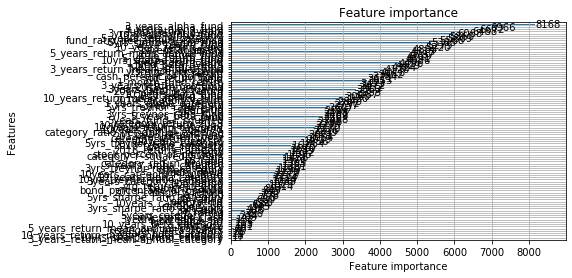

Fitting model 5
Training until validation scores don't improve for 50 rounds
[4]	training's multi_logloss: 1.55337	valid_1's multi_logloss: 1.5555
[8]	training's multi_logloss: 1.51108	valid_1's multi_logloss: 1.51482
[12]	training's multi_logloss: 1.47457	valid_1's multi_logloss: 1.48006
[16]	training's multi_logloss: 1.44103	valid_1's multi_logloss: 1.44823
[20]	training's multi_logloss: 1.41048	valid_1's multi_logloss: 1.41943
[24]	training's multi_logloss: 1.38309	valid_1's multi_logloss: 1.39326
[28]	training's multi_logloss: 1.35715	valid_1's multi_logloss: 1.36884
[32]	training's multi_logloss: 1.33281	valid_1's multi_logloss: 1.3459
[36]	training's multi_logloss: 1.31041	valid_1's multi_logloss: 1.32498
[40]	training's multi_logloss: 1.28903	valid_1's multi_logloss: 1.30515
[44]	training's multi_logloss: 1.26918	valid_1's multi_logloss: 1.28668
[48]	training's multi_logloss: 1.25037	valid_1's multi_logloss: 1.26915
[52]	training's multi_logloss: 1.23237	valid_1's multi_logloss:

[448]	training's multi_logloss: 0.685363	valid_1's multi_logloss: 0.778064
[452]	training's multi_logloss: 0.68314	valid_1's multi_logloss: 0.776415
[456]	training's multi_logloss: 0.681112	valid_1's multi_logloss: 0.774953
[460]	training's multi_logloss: 0.678932	valid_1's multi_logloss: 0.77338
[464]	training's multi_logloss: 0.676701	valid_1's multi_logloss: 0.77167
[468]	training's multi_logloss: 0.674512	valid_1's multi_logloss: 0.770012
[472]	training's multi_logloss: 0.672395	valid_1's multi_logloss: 0.768494
[476]	training's multi_logloss: 0.670344	valid_1's multi_logloss: 0.767075
[480]	training's multi_logloss: 0.668308	valid_1's multi_logloss: 0.765622
[484]	training's multi_logloss: 0.666223	valid_1's multi_logloss: 0.763989
[488]	training's multi_logloss: 0.664175	valid_1's multi_logloss: 0.762519
[492]	training's multi_logloss: 0.662255	valid_1's multi_logloss: 0.761122
[496]	training's multi_logloss: 0.660312	valid_1's multi_logloss: 0.759733
[500]	training's multi_loglo

[892]	training's multi_logloss: 0.525719	valid_1's multi_logloss: 0.669607
[896]	training's multi_logloss: 0.524801	valid_1's multi_logloss: 0.669045
[900]	training's multi_logloss: 0.523854	valid_1's multi_logloss: 0.668432
[904]	training's multi_logloss: 0.522946	valid_1's multi_logloss: 0.667963
[908]	training's multi_logloss: 0.521994	valid_1's multi_logloss: 0.667351
[912]	training's multi_logloss: 0.521083	valid_1's multi_logloss: 0.666777
[916]	training's multi_logloss: 0.520141	valid_1's multi_logloss: 0.666091
[920]	training's multi_logloss: 0.519288	valid_1's multi_logloss: 0.66558
[924]	training's multi_logloss: 0.518404	valid_1's multi_logloss: 0.665104
[928]	training's multi_logloss: 0.517496	valid_1's multi_logloss: 0.664595
[932]	training's multi_logloss: 0.516586	valid_1's multi_logloss: 0.664005
[936]	training's multi_logloss: 0.515647	valid_1's multi_logloss: 0.66342
[940]	training's multi_logloss: 0.514788	valid_1's multi_logloss: 0.66293
[944]	training's multi_loglo

[1760]	training's multi_logloss: 0.409168	valid_1's multi_logloss: 0.609707
[1764]	training's multi_logloss: 0.40892	valid_1's multi_logloss: 0.609593
[1768]	training's multi_logloss: 0.408643	valid_1's multi_logloss: 0.609521
[1772]	training's multi_logloss: 0.408362	valid_1's multi_logloss: 0.609432
[1776]	training's multi_logloss: 0.408074	valid_1's multi_logloss: 0.609303
[1780]	training's multi_logloss: 0.407812	valid_1's multi_logloss: 0.609148
[1784]	training's multi_logloss: 0.407537	valid_1's multi_logloss: 0.609025
[1788]	training's multi_logloss: 0.407238	valid_1's multi_logloss: 0.608903
[1792]	training's multi_logloss: 0.406968	valid_1's multi_logloss: 0.608787
[1796]	training's multi_logloss: 0.406666	valid_1's multi_logloss: 0.60863
[1800]	training's multi_logloss: 0.406459	valid_1's multi_logloss: 0.608512
[1804]	training's multi_logloss: 0.40616	valid_1's multi_logloss: 0.608337
[1808]	training's multi_logloss: 0.405907	valid_1's multi_logloss: 0.608236
[1812]	training

[2208]	training's multi_logloss: 0.384081	valid_1's multi_logloss: 0.599127
[2212]	training's multi_logloss: 0.383886	valid_1's multi_logloss: 0.599069
[2216]	training's multi_logloss: 0.38374	valid_1's multi_logloss: 0.599015
[2220]	training's multi_logloss: 0.383567	valid_1's multi_logloss: 0.598925
[2224]	training's multi_logloss: 0.383389	valid_1's multi_logloss: 0.598847
[2228]	training's multi_logloss: 0.383226	valid_1's multi_logloss: 0.59882
[2232]	training's multi_logloss: 0.383071	valid_1's multi_logloss: 0.598726
[2236]	training's multi_logloss: 0.382862	valid_1's multi_logloss: 0.598634
[2240]	training's multi_logloss: 0.382718	valid_1's multi_logloss: 0.598573
[2244]	training's multi_logloss: 0.382576	valid_1's multi_logloss: 0.59853
[2248]	training's multi_logloss: 0.382439	valid_1's multi_logloss: 0.598466
[2252]	training's multi_logloss: 0.382306	valid_1's multi_logloss: 0.598397
[2256]	training's multi_logloss: 0.382117	valid_1's multi_logloss: 0.598296
[2260]	training

[2644]	training's multi_logloss: 0.369398	valid_1's multi_logloss: 0.593629
[2648]	training's multi_logloss: 0.369277	valid_1's multi_logloss: 0.593565
[2652]	training's multi_logloss: 0.369165	valid_1's multi_logloss: 0.593525
[2656]	training's multi_logloss: 0.369061	valid_1's multi_logloss: 0.593489
[2660]	training's multi_logloss: 0.368954	valid_1's multi_logloss: 0.593418
[2664]	training's multi_logloss: 0.36883	valid_1's multi_logloss: 0.593356
[2668]	training's multi_logloss: 0.368719	valid_1's multi_logloss: 0.593334
[2672]	training's multi_logloss: 0.368578	valid_1's multi_logloss: 0.593272
[2676]	training's multi_logloss: 0.368472	valid_1's multi_logloss: 0.593259
[2680]	training's multi_logloss: 0.368357	valid_1's multi_logloss: 0.593216
[2684]	training's multi_logloss: 0.36825	valid_1's multi_logloss: 0.593174
[2688]	training's multi_logloss: 0.368143	valid_1's multi_logloss: 0.593122
[2692]	training's multi_logloss: 0.36801	valid_1's multi_logloss: 0.593071
[2696]	training

[3084]	training's multi_logloss: 0.358361	valid_1's multi_logloss: 0.58958
[3088]	training's multi_logloss: 0.358262	valid_1's multi_logloss: 0.589556
[3092]	training's multi_logloss: 0.358161	valid_1's multi_logloss: 0.589508
[3096]	training's multi_logloss: 0.358081	valid_1's multi_logloss: 0.589493
[3100]	training's multi_logloss: 0.357961	valid_1's multi_logloss: 0.589445
[3104]	training's multi_logloss: 0.357851	valid_1's multi_logloss: 0.589402
[3108]	training's multi_logloss: 0.357757	valid_1's multi_logloss: 0.589395
[3112]	training's multi_logloss: 0.357669	valid_1's multi_logloss: 0.589368
[3116]	training's multi_logloss: 0.357595	valid_1's multi_logloss: 0.589309
[3120]	training's multi_logloss: 0.357544	valid_1's multi_logloss: 0.589293
[3124]	training's multi_logloss: 0.357475	valid_1's multi_logloss: 0.589248
[3128]	training's multi_logloss: 0.357366	valid_1's multi_logloss: 0.589212
[3132]	training's multi_logloss: 0.357297	valid_1's multi_logloss: 0.589185
[3136]	traini

[3520]	training's multi_logloss: 0.350263	valid_1's multi_logloss: 0.586535
[3524]	training's multi_logloss: 0.350194	valid_1's multi_logloss: 0.586524
[3528]	training's multi_logloss: 0.350128	valid_1's multi_logloss: 0.586487
[3532]	training's multi_logloss: 0.35009	valid_1's multi_logloss: 0.586489
[3536]	training's multi_logloss: 0.350038	valid_1's multi_logloss: 0.586475
[3540]	training's multi_logloss: 0.349963	valid_1's multi_logloss: 0.58645
[3544]	training's multi_logloss: 0.349905	valid_1's multi_logloss: 0.586424
[3548]	training's multi_logloss: 0.349831	valid_1's multi_logloss: 0.586399
[3552]	training's multi_logloss: 0.349781	valid_1's multi_logloss: 0.586384
[3556]	training's multi_logloss: 0.349737	valid_1's multi_logloss: 0.586381
[3560]	training's multi_logloss: 0.34968	valid_1's multi_logloss: 0.586364
[3564]	training's multi_logloss: 0.349639	valid_1's multi_logloss: 0.586353
[3568]	training's multi_logloss: 0.34959	valid_1's multi_logloss: 0.586342
[3572]	training'

[3968]	training's multi_logloss: 0.343427	valid_1's multi_logloss: 0.584346
[3972]	training's multi_logloss: 0.343393	valid_1's multi_logloss: 0.584341
[3976]	training's multi_logloss: 0.343342	valid_1's multi_logloss: 0.584304
[3980]	training's multi_logloss: 0.343305	valid_1's multi_logloss: 0.584279
[3984]	training's multi_logloss: 0.343263	valid_1's multi_logloss: 0.584256
[3988]	training's multi_logloss: 0.343219	valid_1's multi_logloss: 0.584247
[3992]	training's multi_logloss: 0.343195	valid_1's multi_logloss: 0.584252
[3996]	training's multi_logloss: 0.343133	valid_1's multi_logloss: 0.584244
[4000]	training's multi_logloss: 0.343077	valid_1's multi_logloss: 0.584226
[4004]	training's multi_logloss: 0.342995	valid_1's multi_logloss: 0.584178
[4008]	training's multi_logloss: 0.342942	valid_1's multi_logloss: 0.584143
[4012]	training's multi_logloss: 0.342895	valid_1's multi_logloss: 0.584123
[4016]	training's multi_logloss: 0.342841	valid_1's multi_logloss: 0.584112
[4020]	train

[4408]	training's multi_logloss: 0.338008	valid_1's multi_logloss: 0.582722
[4412]	training's multi_logloss: 0.33795	valid_1's multi_logloss: 0.582715
[4416]	training's multi_logloss: 0.337906	valid_1's multi_logloss: 0.582672
[4420]	training's multi_logloss: 0.337869	valid_1's multi_logloss: 0.582662
[4424]	training's multi_logloss: 0.337825	valid_1's multi_logloss: 0.582668
[4428]	training's multi_logloss: 0.33776	valid_1's multi_logloss: 0.582654
[4432]	training's multi_logloss: 0.337718	valid_1's multi_logloss: 0.582665
[4436]	training's multi_logloss: 0.337665	valid_1's multi_logloss: 0.582672
[4440]	training's multi_logloss: 0.337614	valid_1's multi_logloss: 0.582674
[4444]	training's multi_logloss: 0.337586	valid_1's multi_logloss: 0.582676
[4448]	training's multi_logloss: 0.33754	valid_1's multi_logloss: 0.582652
[4452]	training's multi_logloss: 0.337498	valid_1's multi_logloss: 0.582631
[4456]	training's multi_logloss: 0.337441	valid_1's multi_logloss: 0.582607
[4460]	training

[4856]	training's multi_logloss: 0.333217	valid_1's multi_logloss: 0.581299
[4860]	training's multi_logloss: 0.33319	valid_1's multi_logloss: 0.581284
[4864]	training's multi_logloss: 0.333159	valid_1's multi_logloss: 0.58126
[4868]	training's multi_logloss: 0.333112	valid_1's multi_logloss: 0.581249
[4872]	training's multi_logloss: 0.33307	valid_1's multi_logloss: 0.581231
[4876]	training's multi_logloss: 0.333021	valid_1's multi_logloss: 0.581203
[4880]	training's multi_logloss: 0.332986	valid_1's multi_logloss: 0.581176
[4884]	training's multi_logloss: 0.332958	valid_1's multi_logloss: 0.58116
[4888]	training's multi_logloss: 0.332926	valid_1's multi_logloss: 0.581153
[4892]	training's multi_logloss: 0.332895	valid_1's multi_logloss: 0.581153
[4896]	training's multi_logloss: 0.332849	valid_1's multi_logloss: 0.581119
[4900]	training's multi_logloss: 0.332819	valid_1's multi_logloss: 0.581099
[4904]	training's multi_logloss: 0.332775	valid_1's multi_logloss: 0.581082
[4908]	training'

[5720]	training's multi_logloss: 0.325612	valid_1's multi_logloss: 0.578864
[5724]	training's multi_logloss: 0.325594	valid_1's multi_logloss: 0.578855
[5728]	training's multi_logloss: 0.325569	valid_1's multi_logloss: 0.578863
[5732]	training's multi_logloss: 0.325538	valid_1's multi_logloss: 0.578859
[5736]	training's multi_logloss: 0.325504	valid_1's multi_logloss: 0.578851
[5740]	training's multi_logloss: 0.325484	valid_1's multi_logloss: 0.578834
[5744]	training's multi_logloss: 0.325454	valid_1's multi_logloss: 0.578818
[5748]	training's multi_logloss: 0.325422	valid_1's multi_logloss: 0.578809
[5752]	training's multi_logloss: 0.32539	valid_1's multi_logloss: 0.578795
[5756]	training's multi_logloss: 0.325352	valid_1's multi_logloss: 0.578804
[5760]	training's multi_logloss: 0.32532	valid_1's multi_logloss: 0.578796
[5764]	training's multi_logloss: 0.325296	valid_1's multi_logloss: 0.578789
[5768]	training's multi_logloss: 0.325274	valid_1's multi_logloss: 0.578793
[5772]	trainin

[6160]	training's multi_logloss: 0.3223	valid_1's multi_logloss: 0.577936
[6164]	training's multi_logloss: 0.322273	valid_1's multi_logloss: 0.577927
[6168]	training's multi_logloss: 0.32224	valid_1's multi_logloss: 0.57791
[6172]	training's multi_logloss: 0.322218	valid_1's multi_logloss: 0.577917
[6176]	training's multi_logloss: 0.322198	valid_1's multi_logloss: 0.577916
[6180]	training's multi_logloss: 0.32217	valid_1's multi_logloss: 0.577909
[6184]	training's multi_logloss: 0.322146	valid_1's multi_logloss: 0.577905
[6188]	training's multi_logloss: 0.322119	valid_1's multi_logloss: 0.577885
[6192]	training's multi_logloss: 0.322096	valid_1's multi_logloss: 0.577874
[6196]	training's multi_logloss: 0.322079	valid_1's multi_logloss: 0.57787
[6200]	training's multi_logloss: 0.322041	valid_1's multi_logloss: 0.577855
[6204]	training's multi_logloss: 0.322012	valid_1's multi_logloss: 0.577851
[6208]	training's multi_logloss: 0.321983	valid_1's multi_logloss: 0.577836
[6212]	training's 

[6596]	training's multi_logloss: 0.319317	valid_1's multi_logloss: 0.576947
[6600]	training's multi_logloss: 0.319295	valid_1's multi_logloss: 0.576935
[6604]	training's multi_logloss: 0.319277	valid_1's multi_logloss: 0.576931
[6608]	training's multi_logloss: 0.319242	valid_1's multi_logloss: 0.576925
[6612]	training's multi_logloss: 0.319186	valid_1's multi_logloss: 0.576902
[6616]	training's multi_logloss: 0.319163	valid_1's multi_logloss: 0.57691
[6620]	training's multi_logloss: 0.319142	valid_1's multi_logloss: 0.576894
[6624]	training's multi_logloss: 0.31913	valid_1's multi_logloss: 0.576894
[6628]	training's multi_logloss: 0.3191	valid_1's multi_logloss: 0.576877
[6632]	training's multi_logloss: 0.319062	valid_1's multi_logloss: 0.576858
[6636]	training's multi_logloss: 0.319032	valid_1's multi_logloss: 0.576846
[6640]	training's multi_logloss: 0.319005	valid_1's multi_logloss: 0.576831
[6644]	training's multi_logloss: 0.318977	valid_1's multi_logloss: 0.576821
[6648]	training'

[7044]	training's multi_logloss: 0.316459	valid_1's multi_logloss: 0.575986
[7048]	training's multi_logloss: 0.316431	valid_1's multi_logloss: 0.575978
[7052]	training's multi_logloss: 0.316405	valid_1's multi_logloss: 0.575978
[7056]	training's multi_logloss: 0.316385	valid_1's multi_logloss: 0.575984
[7060]	training's multi_logloss: 0.316361	valid_1's multi_logloss: 0.575973
[7064]	training's multi_logloss: 0.316342	valid_1's multi_logloss: 0.575969
[7068]	training's multi_logloss: 0.316331	valid_1's multi_logloss: 0.575964
[7072]	training's multi_logloss: 0.316303	valid_1's multi_logloss: 0.575953
[7076]	training's multi_logloss: 0.316286	valid_1's multi_logloss: 0.57595
[7080]	training's multi_logloss: 0.316266	valid_1's multi_logloss: 0.575939
[7084]	training's multi_logloss: 0.316245	valid_1's multi_logloss: 0.575933
[7088]	training's multi_logloss: 0.316221	valid_1's multi_logloss: 0.575916
[7092]	training's multi_logloss: 0.316208	valid_1's multi_logloss: 0.575912
[7096]	traini

[7908]	training's multi_logloss: 0.311955	valid_1's multi_logloss: 0.574801
[7912]	training's multi_logloss: 0.31194	valid_1's multi_logloss: 0.574792
[7916]	training's multi_logloss: 0.311923	valid_1's multi_logloss: 0.574784
[7920]	training's multi_logloss: 0.311912	valid_1's multi_logloss: 0.574796
[7924]	training's multi_logloss: 0.311896	valid_1's multi_logloss: 0.574796
[7928]	training's multi_logloss: 0.311872	valid_1's multi_logloss: 0.574764
[7932]	training's multi_logloss: 0.311854	valid_1's multi_logloss: 0.574753
[7936]	training's multi_logloss: 0.311847	valid_1's multi_logloss: 0.574753
[7940]	training's multi_logloss: 0.311818	valid_1's multi_logloss: 0.574728
[7944]	training's multi_logloss: 0.311798	valid_1's multi_logloss: 0.574708
[7948]	training's multi_logloss: 0.311785	valid_1's multi_logloss: 0.574691
[7952]	training's multi_logloss: 0.311774	valid_1's multi_logloss: 0.574694
[7956]	training's multi_logloss: 0.311751	valid_1's multi_logloss: 0.574681
[7960]	traini

[8348]	training's multi_logloss: 0.309969	valid_1's multi_logloss: 0.57426
[8352]	training's multi_logloss: 0.309951	valid_1's multi_logloss: 0.574248
[8356]	training's multi_logloss: 0.309938	valid_1's multi_logloss: 0.574239
[8360]	training's multi_logloss: 0.30992	valid_1's multi_logloss: 0.574224
[8364]	training's multi_logloss: 0.30989	valid_1's multi_logloss: 0.574207
[8368]	training's multi_logloss: 0.309882	valid_1's multi_logloss: 0.574213
[8372]	training's multi_logloss: 0.309869	valid_1's multi_logloss: 0.574213
[8376]	training's multi_logloss: 0.30986	valid_1's multi_logloss: 0.574201
[8380]	training's multi_logloss: 0.309848	valid_1's multi_logloss: 0.574196
[8384]	training's multi_logloss: 0.309819	valid_1's multi_logloss: 0.574176
[8388]	training's multi_logloss: 0.309803	valid_1's multi_logloss: 0.574166
[8392]	training's multi_logloss: 0.309782	valid_1's multi_logloss: 0.574144
[8396]	training's multi_logloss: 0.30977	valid_1's multi_logloss: 0.574133
[8400]	training's

[8792]	training's multi_logloss: 0.307998	valid_1's multi_logloss: 0.573678
[8796]	training's multi_logloss: 0.307985	valid_1's multi_logloss: 0.573677
[8800]	training's multi_logloss: 0.307966	valid_1's multi_logloss: 0.573681
[8804]	training's multi_logloss: 0.307946	valid_1's multi_logloss: 0.57369
[8808]	training's multi_logloss: 0.307931	valid_1's multi_logloss: 0.573691
[8812]	training's multi_logloss: 0.307919	valid_1's multi_logloss: 0.573693
[8816]	training's multi_logloss: 0.307899	valid_1's multi_logloss: 0.573696
[8820]	training's multi_logloss: 0.307879	valid_1's multi_logloss: 0.573674
[8824]	training's multi_logloss: 0.307861	valid_1's multi_logloss: 0.573652
[8828]	training's multi_logloss: 0.307848	valid_1's multi_logloss: 0.573675
[8832]	training's multi_logloss: 0.30783	valid_1's multi_logloss: 0.57368
[8836]	training's multi_logloss: 0.307814	valid_1's multi_logloss: 0.573692
[8840]	training's multi_logloss: 0.307809	valid_1's multi_logloss: 0.573693
[8844]	training

[9228]	training's multi_logloss: 0.306282	valid_1's multi_logloss: 0.573281
[9232]	training's multi_logloss: 0.306259	valid_1's multi_logloss: 0.57327
[9236]	training's multi_logloss: 0.306239	valid_1's multi_logloss: 0.573255
[9240]	training's multi_logloss: 0.306229	valid_1's multi_logloss: 0.573247
[9244]	training's multi_logloss: 0.306211	valid_1's multi_logloss: 0.573236
[9248]	training's multi_logloss: 0.306198	valid_1's multi_logloss: 0.573241
[9252]	training's multi_logloss: 0.306173	valid_1's multi_logloss: 0.573253
[9256]	training's multi_logloss: 0.306156	valid_1's multi_logloss: 0.573247
[9260]	training's multi_logloss: 0.306145	valid_1's multi_logloss: 0.573252
[9264]	training's multi_logloss: 0.306118	valid_1's multi_logloss: 0.573249
[9268]	training's multi_logloss: 0.3061	valid_1's multi_logloss: 0.57325
[9272]	training's multi_logloss: 0.306088	valid_1's multi_logloss: 0.57324
[9276]	training's multi_logloss: 0.306078	valid_1's multi_logloss: 0.573237
[9280]	training's

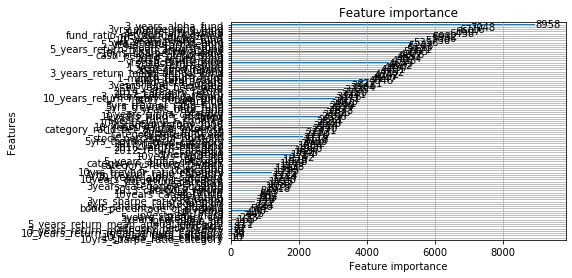

In [231]:
# Fit k models with early-stopping on different training/validation splits
k = 5
predsValid = 0
predsTrain = 0
predsTest = 0
for i in range(0, k):
    print('Fitting model', k)

    # Prepare the data set for fold
    trainData, validData = train_test_split(train,
                                            test_size=0.4,
                                            stratify=train.greatstone_rating)
    trainDataL, trainLabels, trainIDs, trainData = prepLGB(trainData,
                                                     classCol='greatstone_rating',
                                                     IDCol='',
                                                     fDrop=fDrop)
    validDataL, validLabels, validIDs, validData = prepLGB(validData,
                                                     classCol='greatstone_rating',
                                                     IDCol='',
                                                     fDrop=fDrop)
    # Train
    gbm = lgb.train(params,
                    trainDataL,
                    100000,
                    valid_sets=[trainDataL, validDataL],
                    early_stopping_rounds=50,
                    verbose_eval=4)

    # Plot importance
    lgb.plot_importance(gbm)
    plt.show()

    # Predict
    predsValid += gbm.predict(validData,
                              num_iteration=gbm.best_iteration)/k
    predsTrain += gbm.predict(trainData,
                              num_iteration=gbm.best_iteration)/k
    predsTest += gbm.predict(testData,
                             num_iteration=gbm.best_iteration)/k


In [240]:
final =[]
for i in predsTest:
    final.append(np.argmax(i))


In [242]:
np.unique(final)

array([0, 1, 2, 3, 4, 5], dtype=int64)

### Submission

In [243]:
results = pd.DataFrame()
results['fund_id']=test['fund_id']
results['greatstone_rating']=final
print(results.shape)

(5000, 2)


In [244]:
results.head()

fund_id  greatstone_rating
0   264614c6-5ac3-4146-ba26-1674b136cb40                  3
7   08702e4f-c5bb-4f0a-b63b-f9e4a0eb2425                  3
16  cf56db43-046b-49d0-b8f0-90fe9cf8aacf                  3
24  3faa81fc-9640-43d0-8b68-e5b06c65bfe6                  3
28  09e24f3d-7191-4207-887c-98f31c6b59d2                  3

In [245]:
results.to_csv("results.csv",index=False)